### Indoor and Outdoor Analysis

### Box plot of pollutants

#### Importing libraries

In [21]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
from matplotlib.colors import ListedColormap, BoundaryNorm
from PIL import Image
import io
import mysql.connector
import datetime

#### Indoor database credentials

In [24]:
# Database connection details
host = "139.59.34.149"
user = "neemdb" 
password = "(#&pxJ&p7JvhA7<B"
database = "cabh_iaq_db"

#### Global function for calculating the Heat Index using Rothfusz equation

In [27]:
def calculate_heat_index(T, R):
    T_f = T * 9/5 + 32
    if T_f < 80:
        HI_f = 0.5 * (T_f + 61.0 + ((T_f - 68.0) * 1.2) + (R * 0.094))
    else:
        HI_f = (-42.379 + 2.04901523 * T_f + 10.14333127 * R 
                - 0.22475541 * T_f * R - 0.00683783 * T_f**2
                - 0.05481717 * R**2 + 0.00122874 * T_f**2 * R
                + 0.00085282 * T_f * R**2 - 0.00000199 * T_f**2 * R**2)

        if R < 13 and 80 <= T_f <= 112:
            adjustment = ((13-R)/4) * ((17-abs(T_f-95))/17)**0.5
            HI_f -= adjustment
        elif R > 85 and 80 <= T_f <= 87:
            adjustment = ((R-85)/10) * ((87-T_f)/5)
            HI_f += adjustment

    return (HI_f - 32) * 5/9

#### Creating function for fetching indoor data using above credentials

In [30]:
def get_indoor_data(device_id, year, month):
    connection_string = f"mysql+pymysql://{user}:{password}@{host}/{database}"
    engine = create_engine(connection_string)
    query = """
        SELECT datetime, temp, humidity 
        FROM reading_db 
        WHERE deviceID = %s 
        AND YEAR(datetime) = %s 
        AND MONTH(datetime) = %s
        """
    df = pd.read_sql(query, engine, params=(device_id, year, month), parse_dates=['datetime'])
    df.set_index('datetime', inplace=True)

    df['heat_index'] = df.apply(lambda row: 
        calculate_heat_index(row['temp'], row['humidity'])
        if pd.notna(row['temp']) and pd.notna(row['humidity'])
        else np.nan, axis=1)
    return df

### configuration for outdoor data

In [33]:
# Database configuration
DB_CONFIG = {
    'host': '139.59.34.149',
    'user': 'neemdb',
    'password': '(#&pxJ&p7JvhA7<B',
    'database': 'cabh_iaq_db'
}

### Box plot and Line chart of pollutants

Pollutant Data Visualization


Enter Device ID:  1201240074
Enter Year (e.g., 2024):  2024
Enter Month (1–12):  6



Choose Visualization Type:
1 - Box Plot (hourly distribution)
2 - Line Chart (max per hour per day, for all pollutants)


Enter your choice (1 or 2):  2


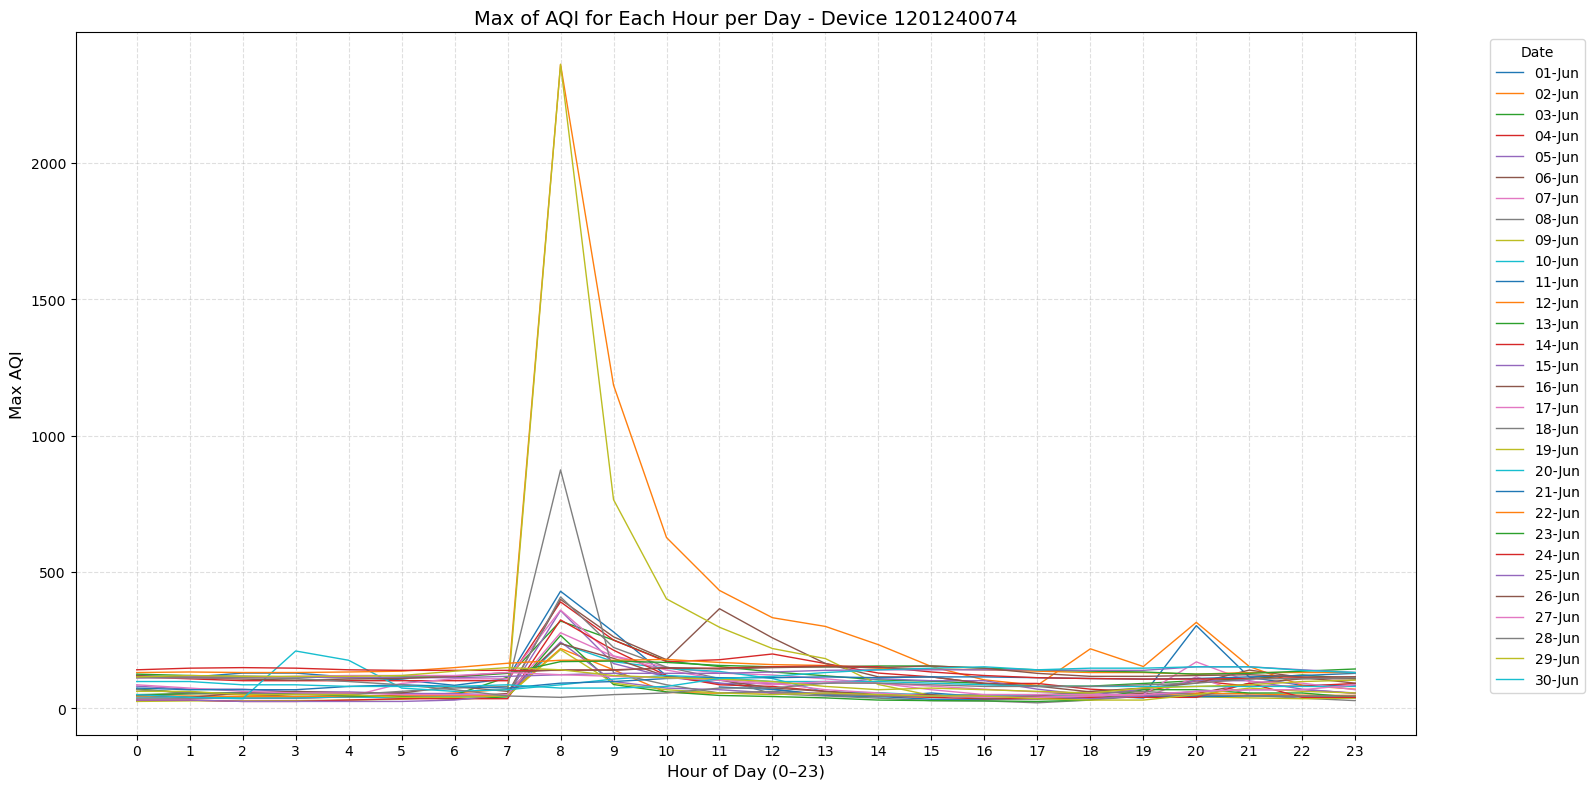

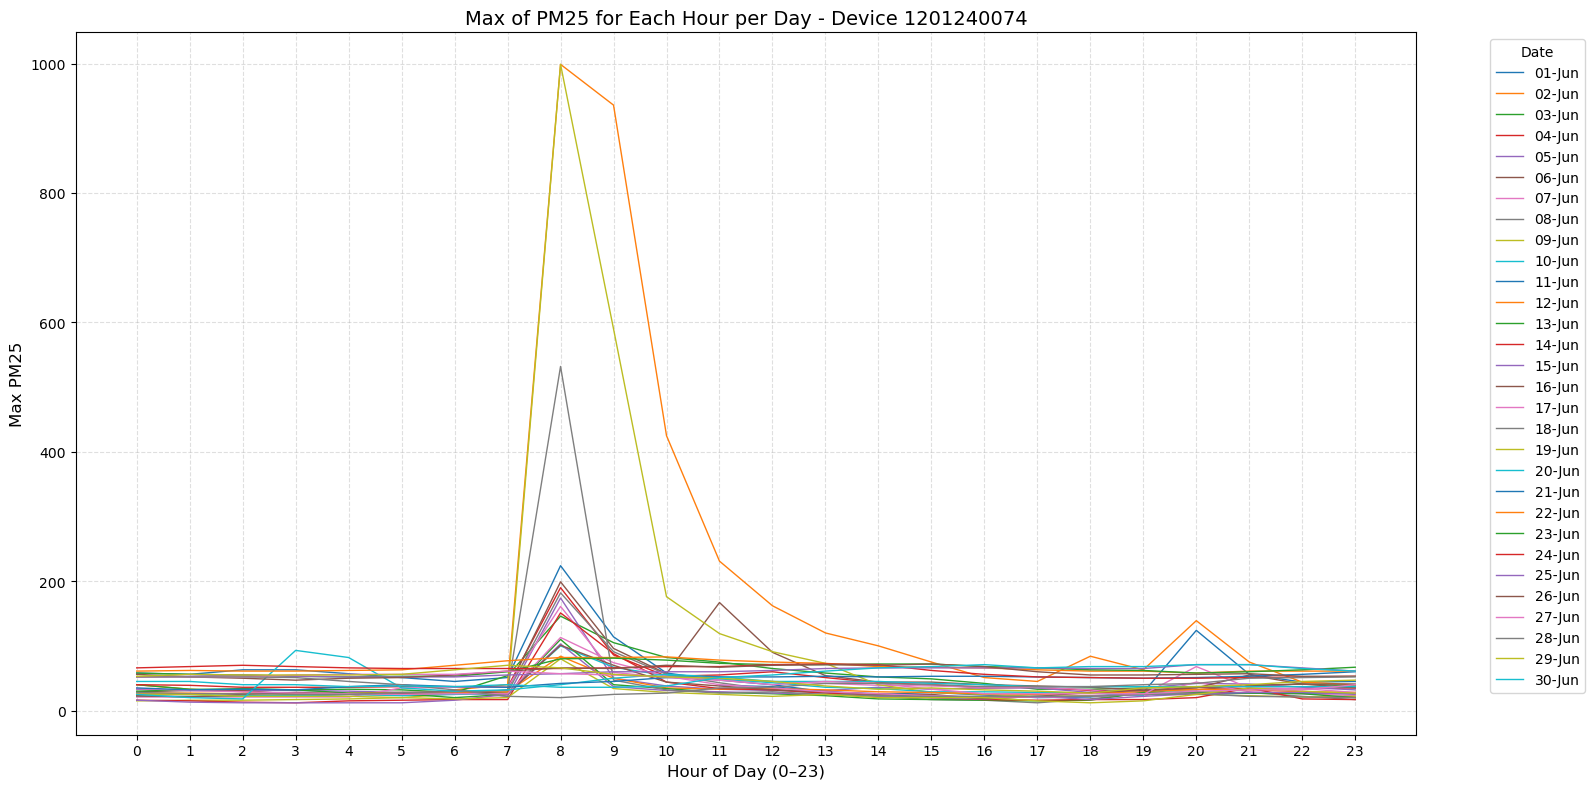

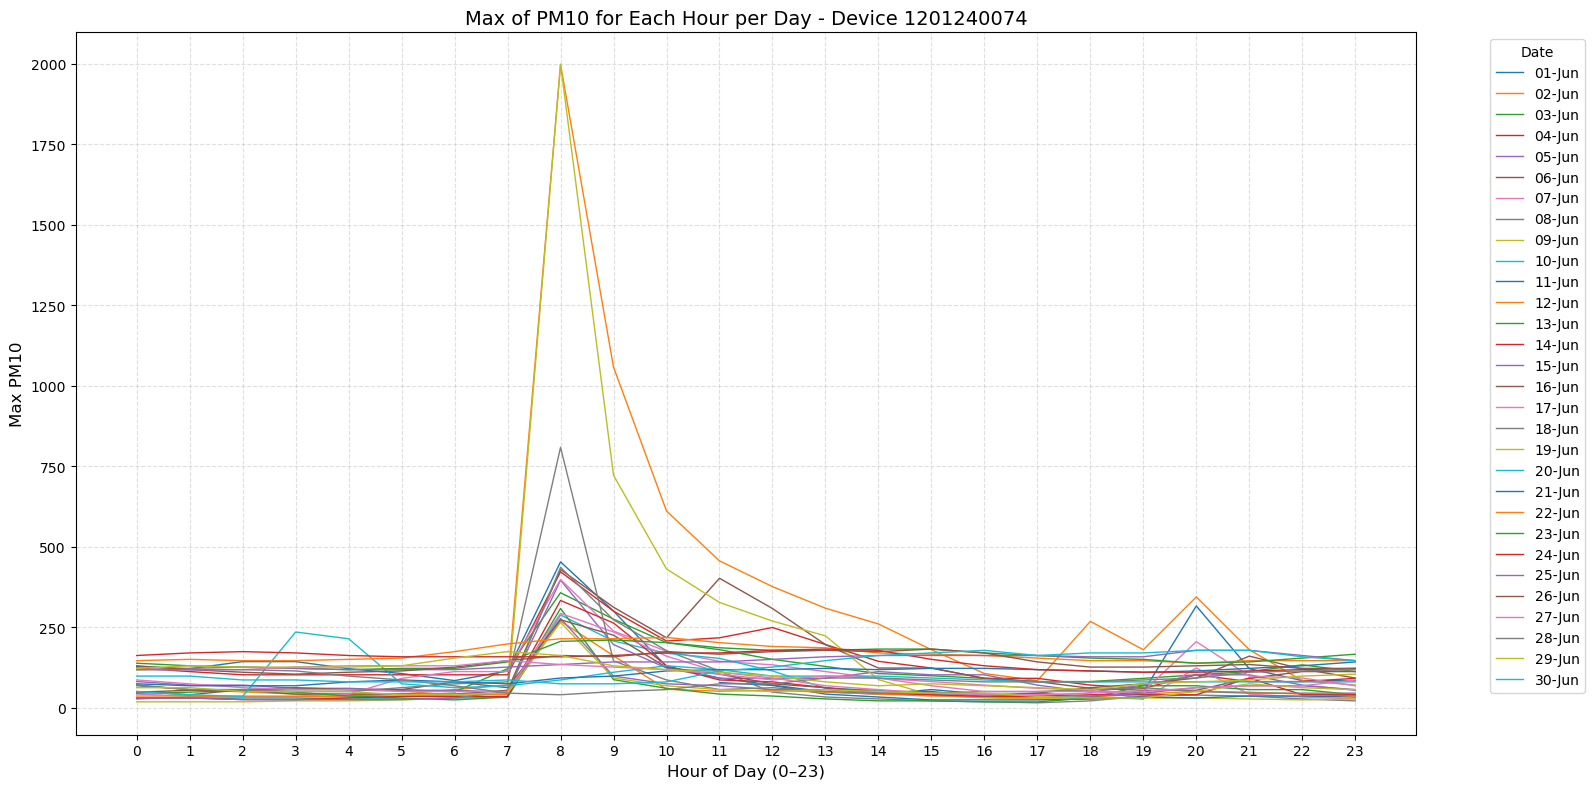

In [74]:
pollutants = ['aqi', 'pm25', 'pm10']

def get_pollutant_data(device_id, year, month):
    """Fetch pollutant data (AQI, PM2.5, PM10) for a specific device and month."""
    try:
        conn = mysql.connector.connect(**DB_CONFIG)
        cursor = conn.cursor()
        query = """
            SELECT datetime, aqi, pm25, pm10
            FROM reading_db
            WHERE deviceID = %s AND YEAR(datetime) = %s AND MONTH(datetime) = %s;
        """
        cursor.execute(query, (device_id, year, month))
        data = cursor.fetchall()

        df = pd.DataFrame(data, columns=['datetime', 'aqi', 'pm25', 'pm10'])
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)

        # Remove bad readings (zeros and specific dates)
        df = df[(df[['aqi', 'pm25', 'pm10']] != 0).all(axis=1)]
        # df = df[~pd.Series(df.index.date).isin([
        #     pd.to_datetime('2024-06-02').date(),
        #     pd.to_datetime('2024-06-09').date()
        # ]).values]

        return df

    except mysql.connector.Error as err:
        print(f"Database error: {err}")
        return pd.DataFrame()

    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()


def plot_pollutant_boxplots(device_id, year, month):
    """Create box plots for AQI, PM2.5, and PM10 by hour."""
    df = get_pollutant_data(device_id, year, month)
    if df.empty:
        print(f"No data available for device {device_id} in {month}/{year}")
        return

    df['hour'] = df.index.hour
    pollutants = ['aqi', 'pm25', 'pm10']
    fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

    for i, pollutant in enumerate(pollutants):
        sns.boxplot(x='hour', y=pollutant, data=df, ax=axes[i], hue='hour', palette='Set3', legend=False)
        axes[i].set_title(f'Hourly Box Plot for {pollutant.upper()} - Device {device_id}')
        axes[i].set_xlabel('Hour of Day (0-23)')
        axes[i].set_ylabel(pollutant.upper())
        axes[i].grid(True, axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout(h_pad=2.5)
    # filename = f'boxplot_{device_id}_{month}_{year}.png'
    # plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()
    # print(f"Saved box plots as: {filename}")


def plot_daily_hourly_max_pollutant(device_id, year, month, pollutant):
    """Plot a line chart: max value of the pollutant for each hour per day in the selected month."""
    df = get_pollutant_data(device_id, year, month)
    if df.empty:
        print(f"No data available for device {device_id} in {month}/{year}")
        return

    # Create 'date' and 'hour' columns
    df['date'] = df.index.date
    df['hour'] = df.index.hour

    # Group by date and hour, get max value for the selected pollutant
    grouped = df.groupby(['date', 'hour'])[pollutant].max().reset_index()

    # Pivot for plotting: rows = hour, columns = date, values = pollutant max
    pivot_df = grouped.pivot(index='hour', columns='date', values=pollutant)

    # Plot
    plt.figure(figsize=(16, 8))
    for col in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[col], label=col.strftime('%d-%b'), linewidth=1)

    plt.title(f'Max of {pollutant.upper()} for Each Hour per Day - Device {device_id}', fontsize=14)
    plt.xlabel('Hour of Day (0–23)', fontsize=12)
    plt.ylabel(f'Max {pollutant.upper()}', fontsize=12)
    plt.xticks(range(0, 24))
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # filename = f'hourly_max_{pollutant}_{device_id}_{month}_{year}.png'
    # plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    # print(f"Saved chart as: {filename}")



if __name__ == '__main__':
    print("Pollutant Data Visualization")
    device_id = input("Enter Device ID: ")
    year = int(input("Enter Year (e.g., 2024): "))
    month = int(input("Enter Month (1–12): "))
    print("\nChoose Visualization Type:")
    print("1 - Box Plot (hourly distribution)")
    print("2 - Line Chart (max per hour per day, for all pollutants)")

    choice = input("Enter your choice (1 or 2): ")
    if choice == '1':
        plot_pollutant_boxplots(device_id, year, month)

    elif choice == '2':
        for pollutant in pollutants:
            plot_daily_hourly_max_pollutant(device_id, year, month, pollutant)

    else:
        print("Invalid choice. Please enter 1 or 2.")




### Addition of Scatter Plot 

Pollutant Data Visualization


Enter Device ID:  1201240074
Enter Year (e.g., 2024):  2024
Enter Month (1–12):  6



Choose Visualization Type:
1 - Box Plot (hourly distribution)
2 - Line Chart (max per hour per day, for all pollutants)
3 - Scatter Plot (INdoor vs Outdoor)


Enter your choice (1, 2 or 3):  3
Enter Outdoor Device ID:  DELCPCB005


Enter time intervals (e.g., 7-9,12-13,20-21):


Time intervals:  7-9,12-13,20-21


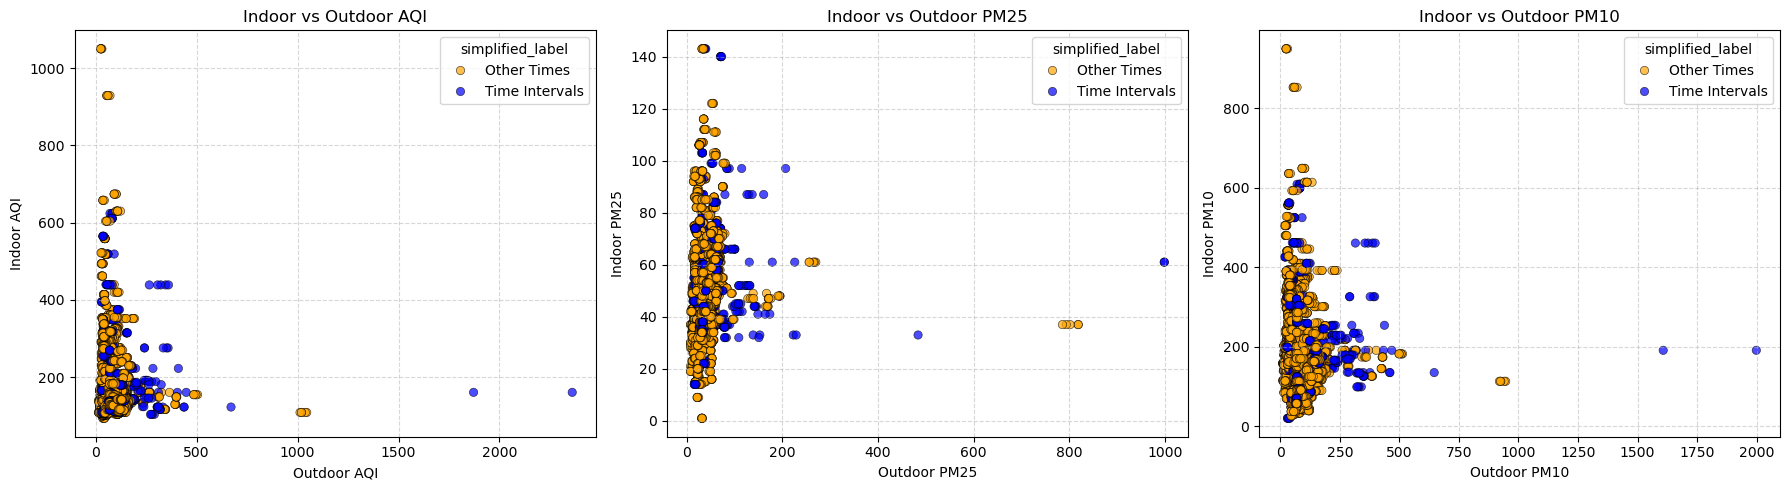

Saved time-separated scatter plot as: indoor_vs_outdoor_time_filtered_1201240074_DELCPCB005_6_2024.png


In [16]:

def plot_indoor_vs_outdoor_scatter(indoor_device_id, outdoor_device_id, year, month, time_intervals):
    """
    Create scatter plots comparing indoor vs outdoor pollutant values, 
    color-coded by user-defined time intervals.
    
    time_intervals: list of (start_hour, end_hour) tuples
    """
    try:
        conn = mysql.connector.connect(**DB_CONFIG)
        cursor = conn.cursor()

        # Outdoor data
        outdoor_query = """
            SELECT datetime, pm25, pm10, aqi
            FROM cpcb_data
            WHERE deviceID = %s AND YEAR(datetime) = %s AND MONTH(datetime) = %s;
        """
        cursor.execute(outdoor_query, (outdoor_device_id, year, month))
        outdoor_data = cursor.fetchall()
        outdoor_df = pd.DataFrame(outdoor_data, columns=['datetime', 'pm25_outdoor', 'pm10_outdoor', 'aqi_outdoor'])
        outdoor_df['datetime'] = pd.to_datetime(outdoor_df['datetime'])
        outdoor_df = outdoor_df[(outdoor_df[['aqi_outdoor', 'pm25_outdoor', 'pm10_outdoor']] != 0).all(axis=1)]

        indoor_df = get_pollutant_data(device_id, year, month)
        
        # Reset index to keep datetime as a column
        indoor_df = indoor_df.reset_index()
        outdoor_df = outdoor_df.reset_index()
        
        # Round to nearest 5 minutes to align
        indoor_df['rounded_time'] = indoor_df['datetime'].dt.floor('5min')
        outdoor_df['rounded_time'] = outdoor_df['datetime'].dt.floor('5min')

        # Merge on rounded_time
        merged_df = pd.merge(indoor_df, outdoor_df, 
                           on='rounded_time',
                           how='inner',
                           suffixes=('_indoor', '_outdoor'))
        
        if merged_df.empty:
            print("No aligned indoor and outdoor data available.")
            return

        # Add hour column using datetime_indoor
        merged_df['hour'] = merged_df['datetime_indoor'].dt.hour

        def classify_interval(hour):
            for idx, (start, end) in enumerate(time_intervals):
                if start <= hour < end:
                    return f"Interval {idx+1} ({start}-{end})"
            return "Other Times"

        merged_df['time_label'] = merged_df['hour'].apply(classify_interval)

        # Plot
        pollutants = ['aqi', 'pm25', 'pm10']
        plt.figure(figsize=(18, 5))

        # Simplify time labels to just "Time Intervals" and "Other Times"
        merged_df['simplified_label'] = merged_df['time_label'].apply(
            lambda x: 'Time Intervals' if 'Interval' in x else 'Other Times'
        )

        # merged_df.to_csv('indoor_outdoor.csv')
        # Define colors with simplified labels
        colors = {
            'Time Intervals': 'blue',
            'Other Times': 'orange'
        }

        for i, pollutant in enumerate(pollutants):
            plt.subplot(1, 3, i + 1)
            sns.scatterplot(
                data=merged_df,
                x=f'{pollutant}_indoor',
                y=f'{pollutant}_outdoor',
                hue='simplified_label',
                palette=colors,
                alpha=0.7,
                edgecolor='k'
            )
            plt.xlabel(f'Outdoor {pollutant.upper()}')
            plt.ylabel(f'Indoor {pollutant.upper()}')
            plt.title(f'Indoor vs Outdoor {pollutant.upper()}')
            plt.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        # filename = f'indoor_vs_outdoor_time_filtered_{indoor_device_id}_{outdoor_device_id}_{month}_{year}.png'
        # plt.savefig(filename, dpi=300)
        plt.show()
        # print(f"Saved time-separated scatter plot as: {filename}")

    except mysql.connector.Error as err:
        print(f"Database error: {err}")

    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()
        
if __name__ == '__main__':
    print("Pollutant Data Visualization")
    device_id = input("Enter Device ID: ")
    year = int(input("Enter Year (e.g., 2024): "))
    month = int(input("Enter Month (1–12): "))
    print("\nChoose Visualization Type:")
    print("1 - Box Plot (hourly distribution)")
    print("2 - Line Chart (max per hour per day, for all pollutants)")
    print("3 - Scatter Plot (INdoor vs Outdoor)")

    choice = input("Enter your choice (1, 2 or 3): ")
    if choice == '1':
        plot_pollutant_boxplots(device_id, year, month)

    elif choice == '2':
        for pollutant in pollutants:
            plot_daily_hourly_max_pollutant(device_id, year, month, pollutant)

    elif choice == '3':
        indoor_device_id = device_id
        outdoor_device_id = input("Enter Outdoor Device ID: ")
        
        print("Enter time intervals (e.g., 7-9,12-13,20-21):")
        intervals_input = input("Time intervals: ")
        time_intervals = []
        for part in intervals_input.split(','):
            start, end = map(int, part.split('-'))
            time_intervals.append((start, end))
    
        plot_indoor_vs_outdoor_scatter(indoor_device_id, outdoor_device_id, year, month, time_intervals)
        
    else:
        print("Invalid choice. Please enter 1 or 2.")

### without rounding off the time interval of outdoor df and resample with hourly average values

Pollutant Data Visualization


Enter Device ID:  1201240074
Enter Year (e.g., 2024):  2024
Enter Month (1–12):  6



Choose Visualization Type:
1 - Box Plot (hourly distribution)
2 - Line Chart (max per hour per day, for all pollutants)
3 - Scatter Plot (INdoor vs Outdoor)


Enter your choice (1, 2 or 3):  2


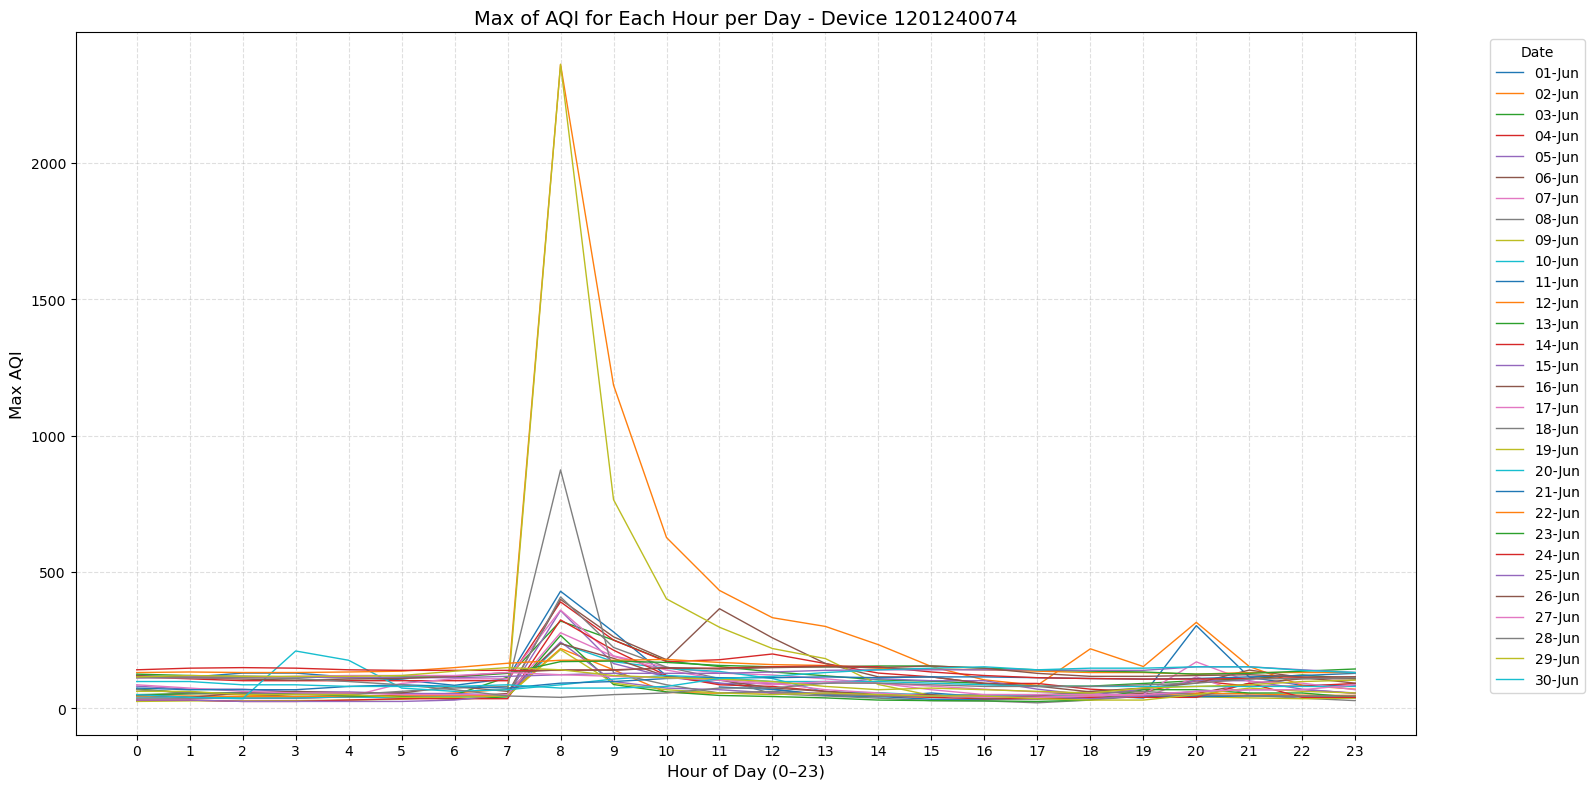

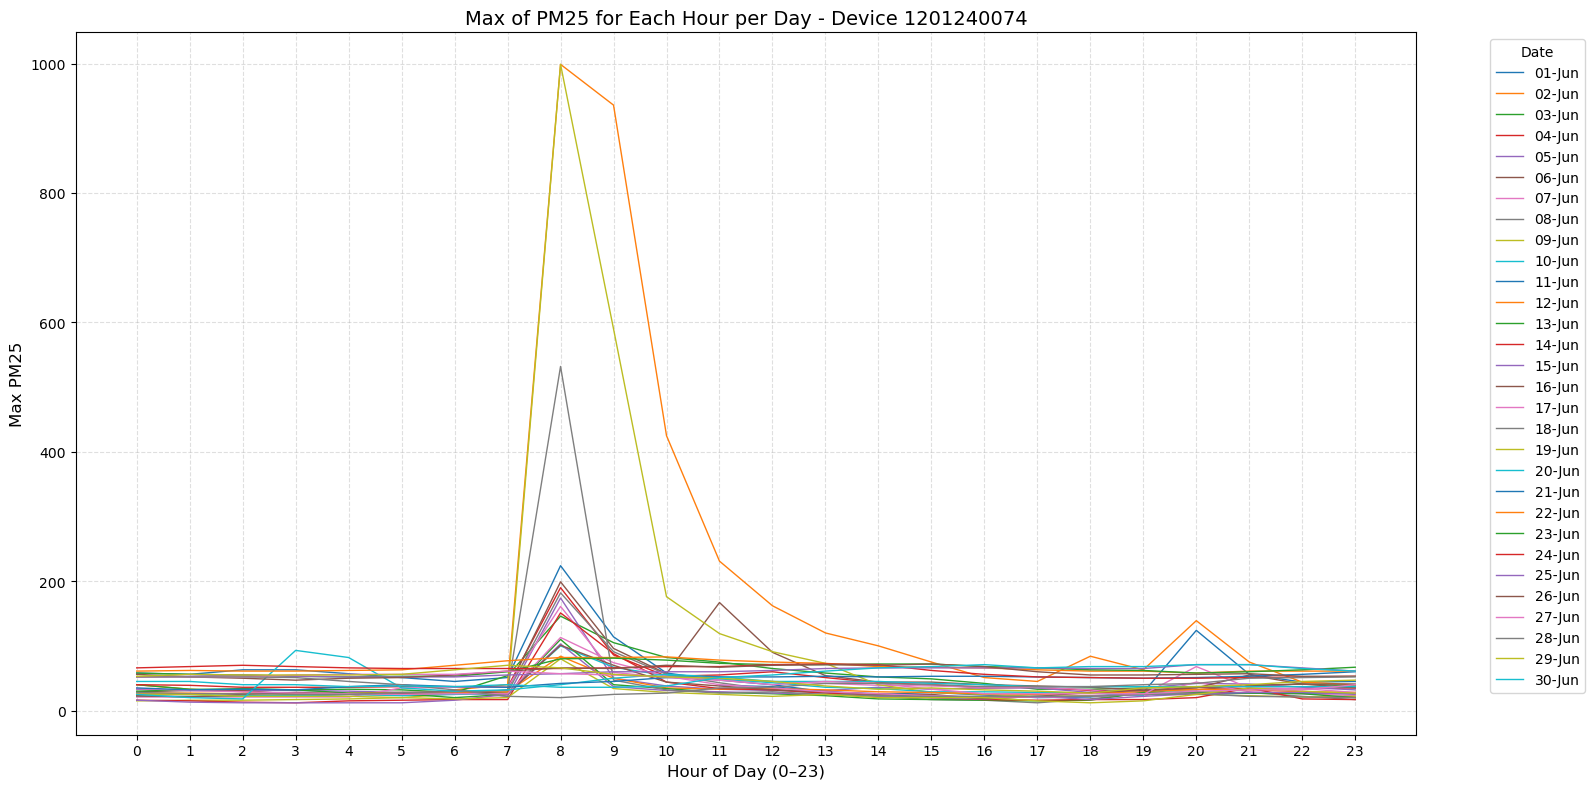

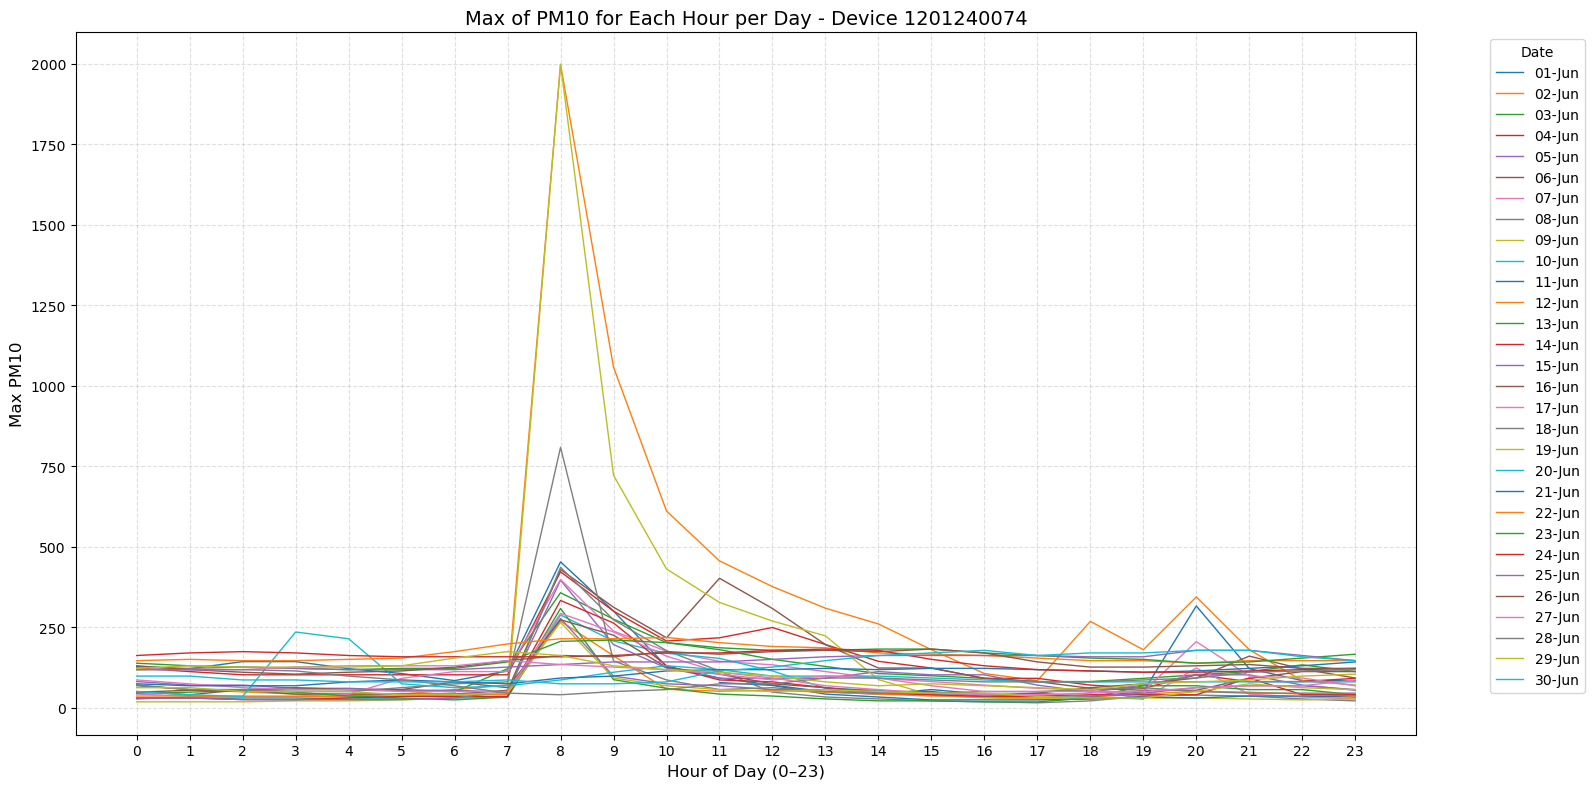

In [76]:
pollutants = ['aqi', 'pm25', 'pm10']

def plot_indoor_vs_outdoor_scatter(indoor_device_id, outdoor_device_id, year, month, time_intervals):
    """
    Create scatter plots comparing indoor vs outdoor pollutant values, 
    color-coded by user-defined time intervals.
    
    time_intervals: list of (start_hour, end_hour) tuples
    """
    try:
        conn = mysql.connector.connect(**DB_CONFIG)
        cursor = conn.cursor()

        # Get outdoor data first
        outdoor_query = """
            SELECT datetime, pm25, pm10, aqi
            FROM cpcb_data
            WHERE deviceID = %s AND YEAR(datetime) = %s AND MONTH(datetime) = %s;
        """
        cursor.execute(outdoor_query, (outdoor_device_id, year, month))
        outdoor_data = cursor.fetchall()
        outdoor_df = pd.DataFrame(outdoor_data, columns=['datetime', 'pm25_outdoor', 'pm10_outdoor', 'aqi_outdoor'])
        outdoor_df['datetime'] = pd.to_datetime(outdoor_df['datetime'])
        outdoor_df = outdoor_df[(outdoor_df[['aqi_outdoor', 'pm25_outdoor', 'pm10_outdoor']] != 0).all(axis=1)]
        
        if outdoor_df.empty:
            print("No outdoor data available.")
            return

        # Extract date and hour for grouping
        outdoor_df['date_hour'] = outdoor_df['datetime'].dt.strftime('%Y-%m-%d %H:00:00')
        outdoor_df['hour'] = outdoor_df['datetime'].dt.hour
        # Calculate hourly averages for each day for outdoor data
        outdoor_hourly = outdoor_df.groupby('date_hour').agg({
            'pm25_outdoor': 'mean',
            'pm10_outdoor': 'mean',
            'aqi_outdoor': 'mean',
            'hour': 'first'  # Keep the hour information
        }).reset_index()
        
        # Get indoor data for the same time range
        min_date = outdoor_df['datetime'].min().strftime('%Y-%m-%d %H:%M:%S')
        max_date = outdoor_df['datetime'].max().strftime('%Y-%m-%d %H:%M:%S')
        
        indoor_query = f"""
            SELECT datetime, aqi, pm25, pm10
            FROM reading_db
            WHERE deviceID = %s 
            AND datetime >= %s 
            AND datetime <= %s;
        """
        cursor.execute(indoor_query, (indoor_device_id, min_date, max_date))
        indoor_data = cursor.fetchall()
        indoor_df = pd.DataFrame(indoor_data, columns=['datetime', 'aqi_indoor', 'pm25_indoor', 'pm10_indoor'])
        indoor_df['datetime'] = pd.to_datetime(indoor_df['datetime'])
        indoor_df = indoor_df[(indoor_df[['aqi_indoor', 'pm25_indoor', 'pm10_indoor']] != 0).all(axis=1)]
        
        # Extract date and hour for grouping
        indoor_df['date_hour'] = indoor_df['datetime'].dt.strftime('%Y-%m-%d %H:00:00')
        indoor_df = indoor_df.dropna()
        # Calculate hourly averages for each day for indoor data
        indoor_hourly = indoor_df.groupby('date_hour').agg({
            'pm25_indoor': 'mean',
            'pm10_indoor': 'mean',
            'aqi_indoor': 'mean'
        }).reset_index()
        
        # Merge hourly data
        merged_df = pd.merge(outdoor_hourly, indoor_hourly, on='date_hour', how='left')
        merged_df['datetime'] = pd.to_datetime(merged_df['date_hour'])
        
        # Remove rows where indoor data is missing
        merged_df = merged_df.dropna()

        if merged_df.empty:
            print("No matching indoor and outdoor data available.")
            return

        def classify_interval(hour):
            for idx, (start, end) in enumerate(time_intervals):
                if start <= hour < end:
                    return f"Interval {idx+1} ({start}-{end})"
            return "Other Times"

        merged_df['time_label'] = merged_df['hour'].apply(classify_interval)

        # Plot
        pollutants = ['aqi', 'pm25', 'pm10']
        plt.figure(figsize=(18, 5))

        # Simplify time labels
        merged_df['simplified_label'] = merged_df['time_label'].apply(
            lambda x: 'Time Intervals' if 'Interval' in x else 'Other Times'
        )

        # Save the data with datetime information
        # merged_df.to_csv('testing_1201240074.csv', index=False)
        
        colors = {
            'Time Intervals': 'blue',
            'Other Times': 'orange'
        }

        for i, pollutant in enumerate(pollutants):
            plt.subplot(1, 3, i + 1)
            sns.scatterplot(
                data=merged_df,
                y=f'{pollutant}_outdoor',
                x=f'{pollutant}_indoor',
                hue='simplified_label',
                palette=colors,
                alpha=0.7,
                edgecolor='k'
            )
            plt.xlabel(f'Outdoor {pollutant.upper()} (Hourly Avg)')
            plt.ylabel(f'Indoor {pollutant.upper()} (Hourly Avg)')
            plt.title(f'Indoor vs Outdoor {pollutant.upper()}\nHourly Averages for {month}/{year}')
            plt.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        # filename = f'indoor_vs_outdoor_hourly_monthly_{indoor_device_id}_{outdoor_device_id}_{month}_{year}.png'
        # plt.savefig(filename, dpi=300)
        plt.show()
        # print(f"Saved hourly average scatter plot as: {filename}")

    except mysql.connector.Error as err:
        print(f"Database error: {err}")

    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()
        
if __name__ == '__main__':
    print("Pollutant Data Visualization")
    device_id = input("Enter Device ID: ")
    year = int(input("Enter Year (e.g., 2024): "))
    month = int(input("Enter Month (1–12): "))
    print("\nChoose Visualization Type:")
    print("1 - Box Plot (hourly distribution)")
    print("2 - Line Chart (max per hour per day, for all pollutants)")
    print("3 - Scatter Plot (INdoor vs Outdoor)")

    choice = input("Enter your choice (1, 2 or 3): ")
    if choice == '1':
        plot_pollutant_boxplots(device_id, year, month)

    elif choice == '2':
        for pollutant in pollutants:
            plot_daily_hourly_max_pollutant(device_id, year, month, pollutant)

    elif choice == '3':
        indoor_device_id = device_id
        outdoor_device_id = input("Enter Outdoor Device ID: ")
        
        print("Enter time intervals (e.g., 7-9,12-13,20-21):")
        intervals_input = input("Time intervals: ")
        time_intervals = []
        for part in intervals_input.split(','):
            start, end = map(int, part.split('-'))
            time_intervals.append((start, end))
    
        plot_indoor_vs_outdoor_scatter(indoor_device_id, outdoor_device_id, year, month, time_intervals)
        
    else:
        print("Invalid choice. Please enter 1, 2, or 3.")

### Comparing different device ids


Pollutant Data Visualization
Enter 3 Device IDs:


Enter Device ID #1:  1201240074
Enter Device ID #2:  1201240076
Enter Device ID #3:  1201240079
Enter Year (e.g., 2024):  2024
Enter Month (1–12):  6



Choose Visualization Type:
1 - Box Plot (hourly distribution)
2 - Line Chart (max per hour per day, for all pollutants)
3 - Scatter Plot (Indoor vs Outdoor)


Enter your choice (1, 2 or 3):  2



Generating Line Charts for Device 1201240074


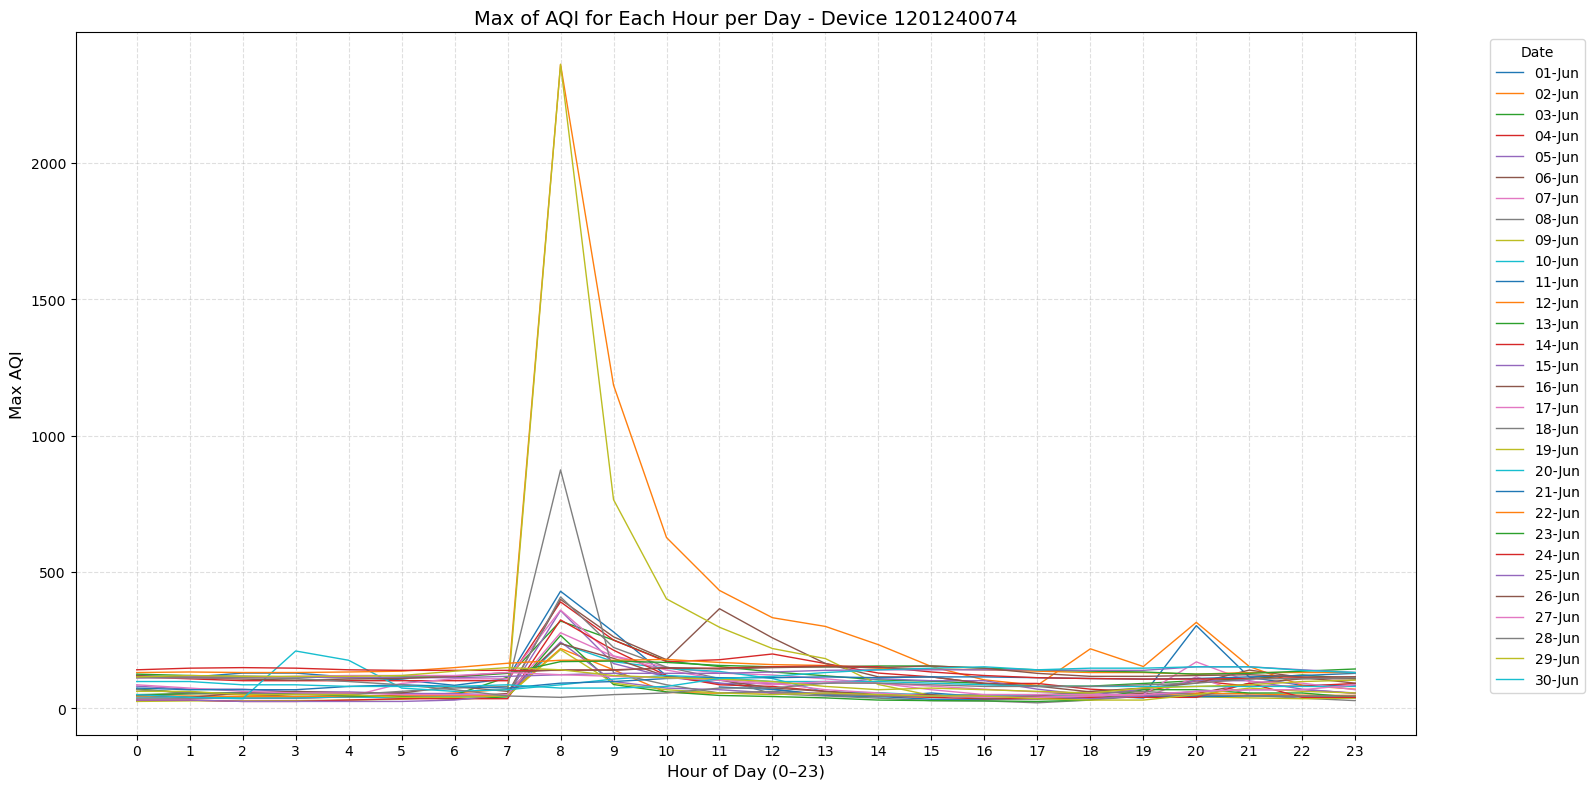

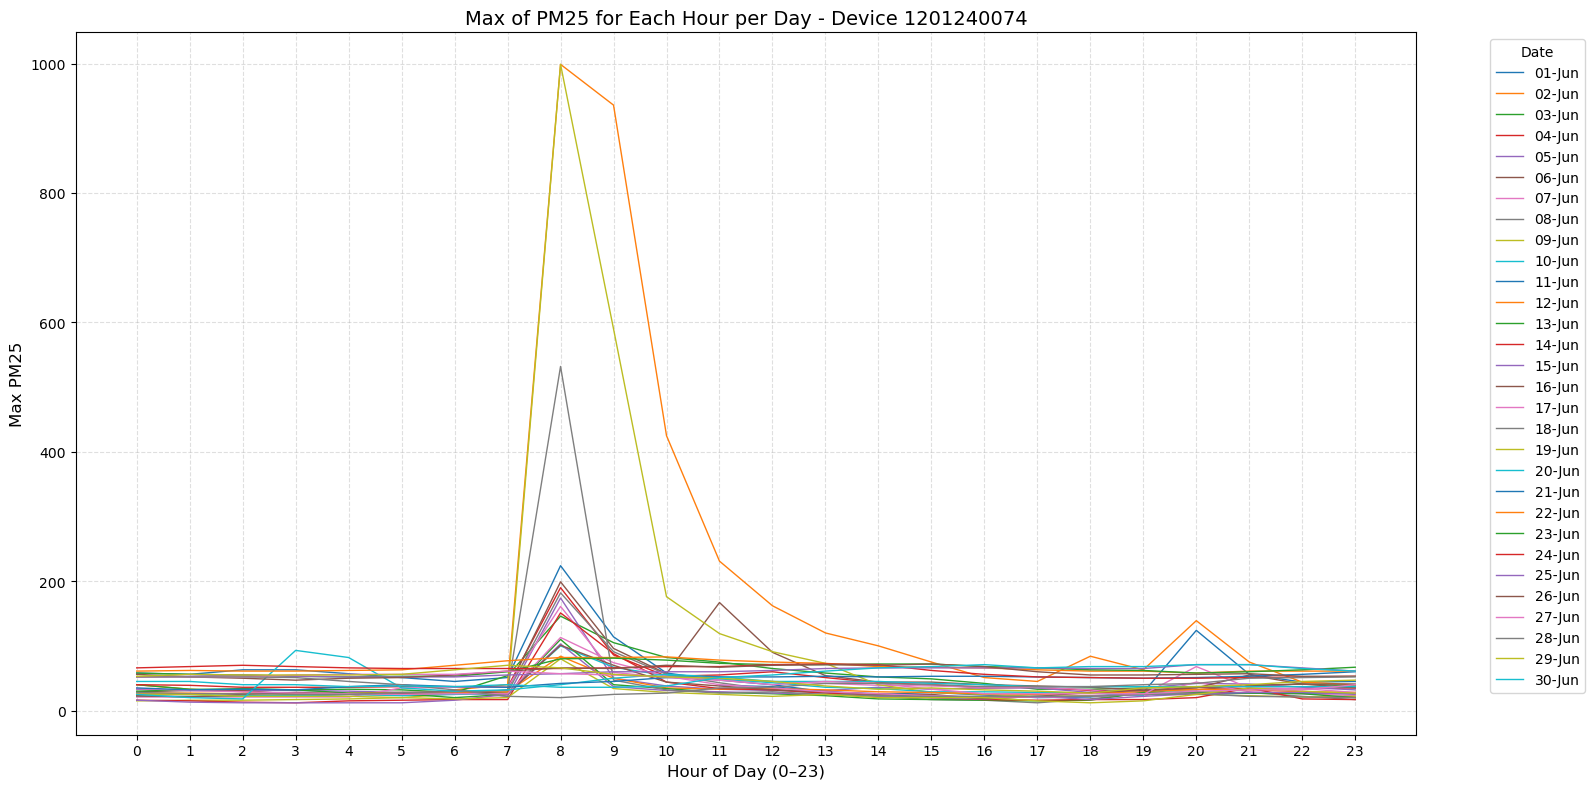

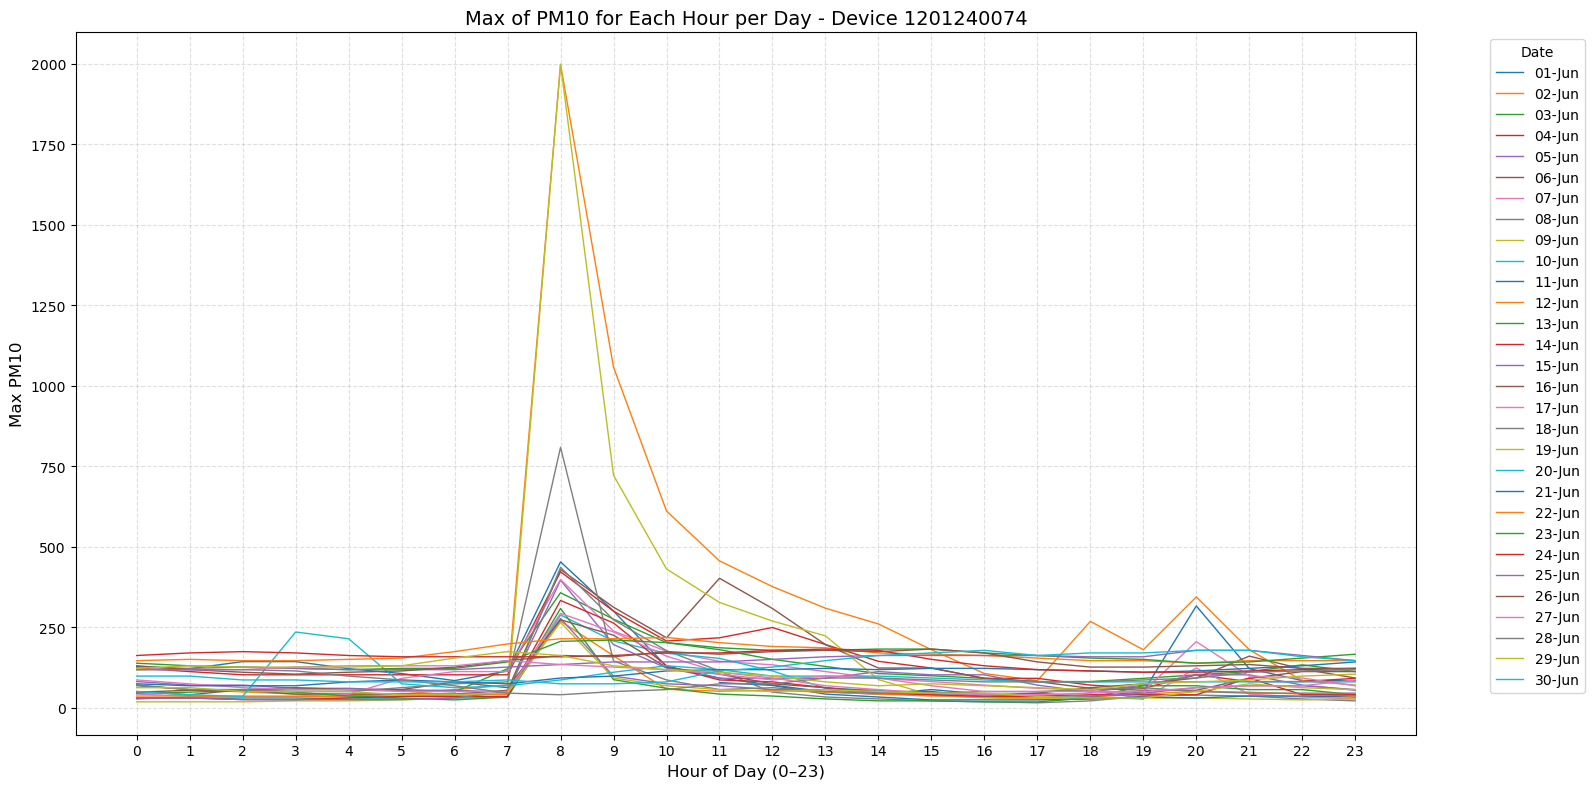


Generating Line Charts for Device 1201240076


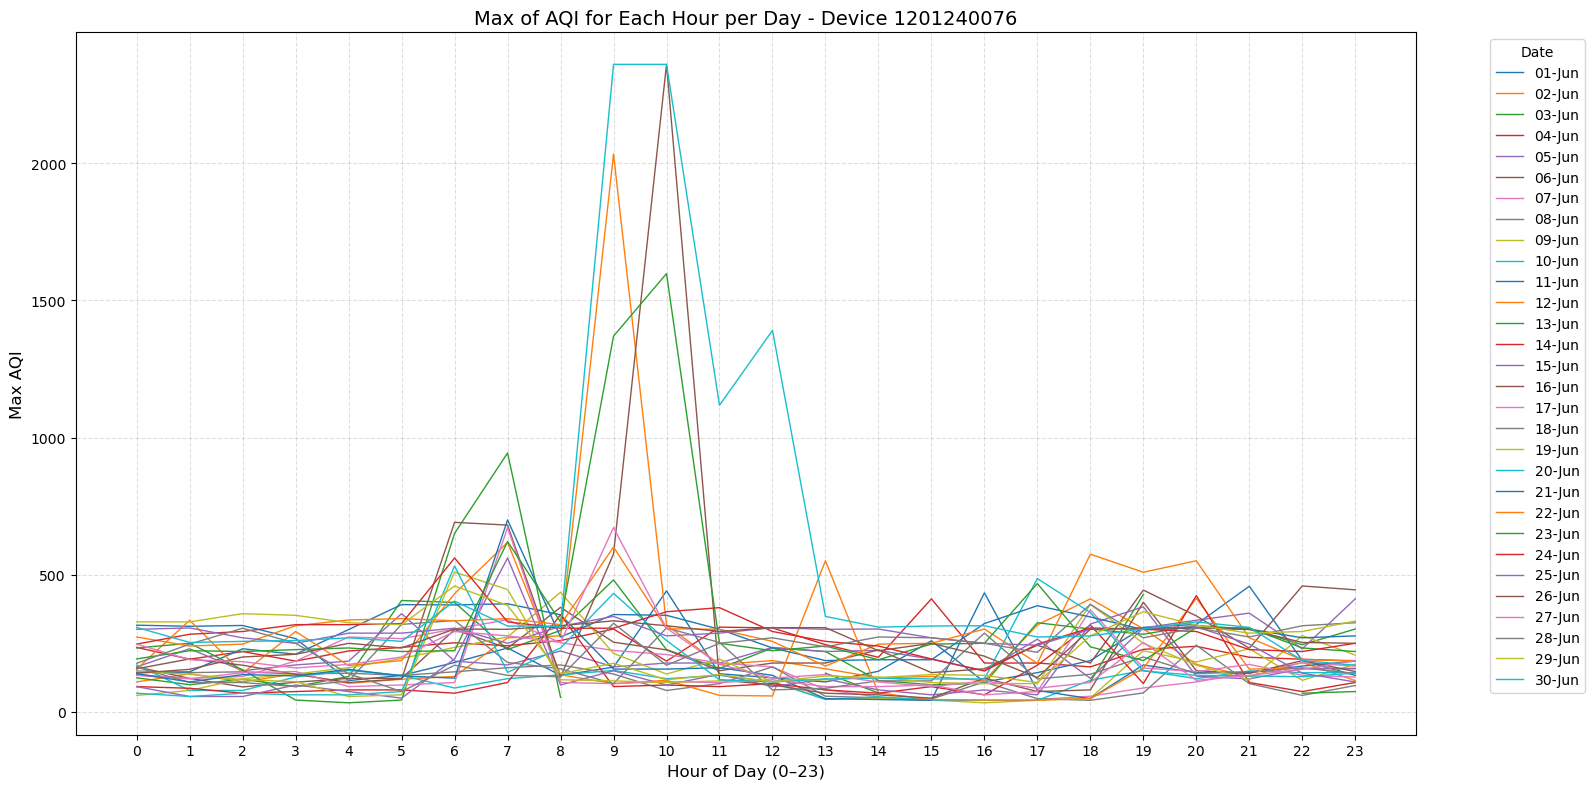

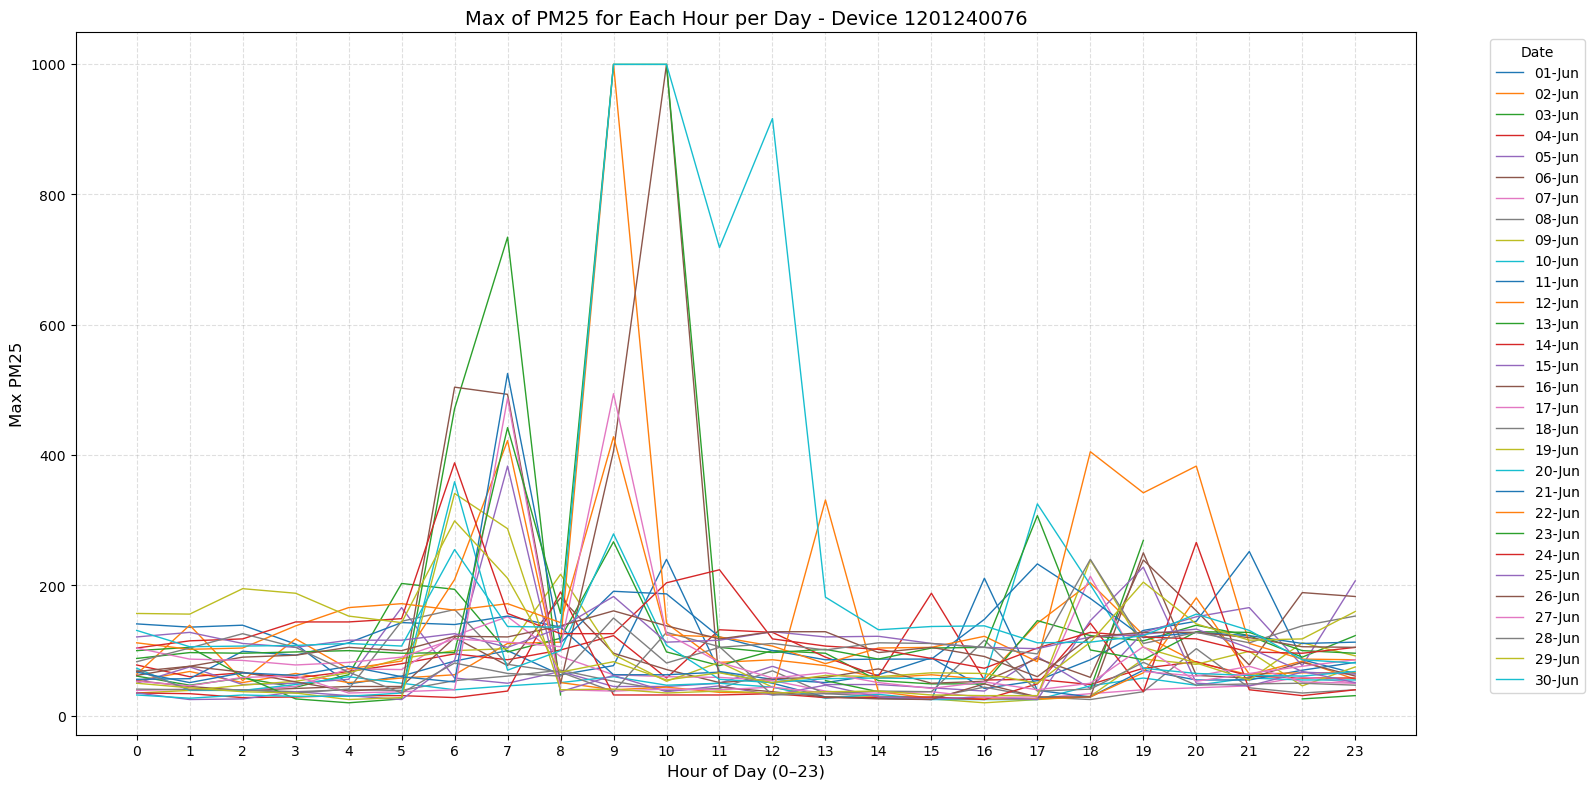

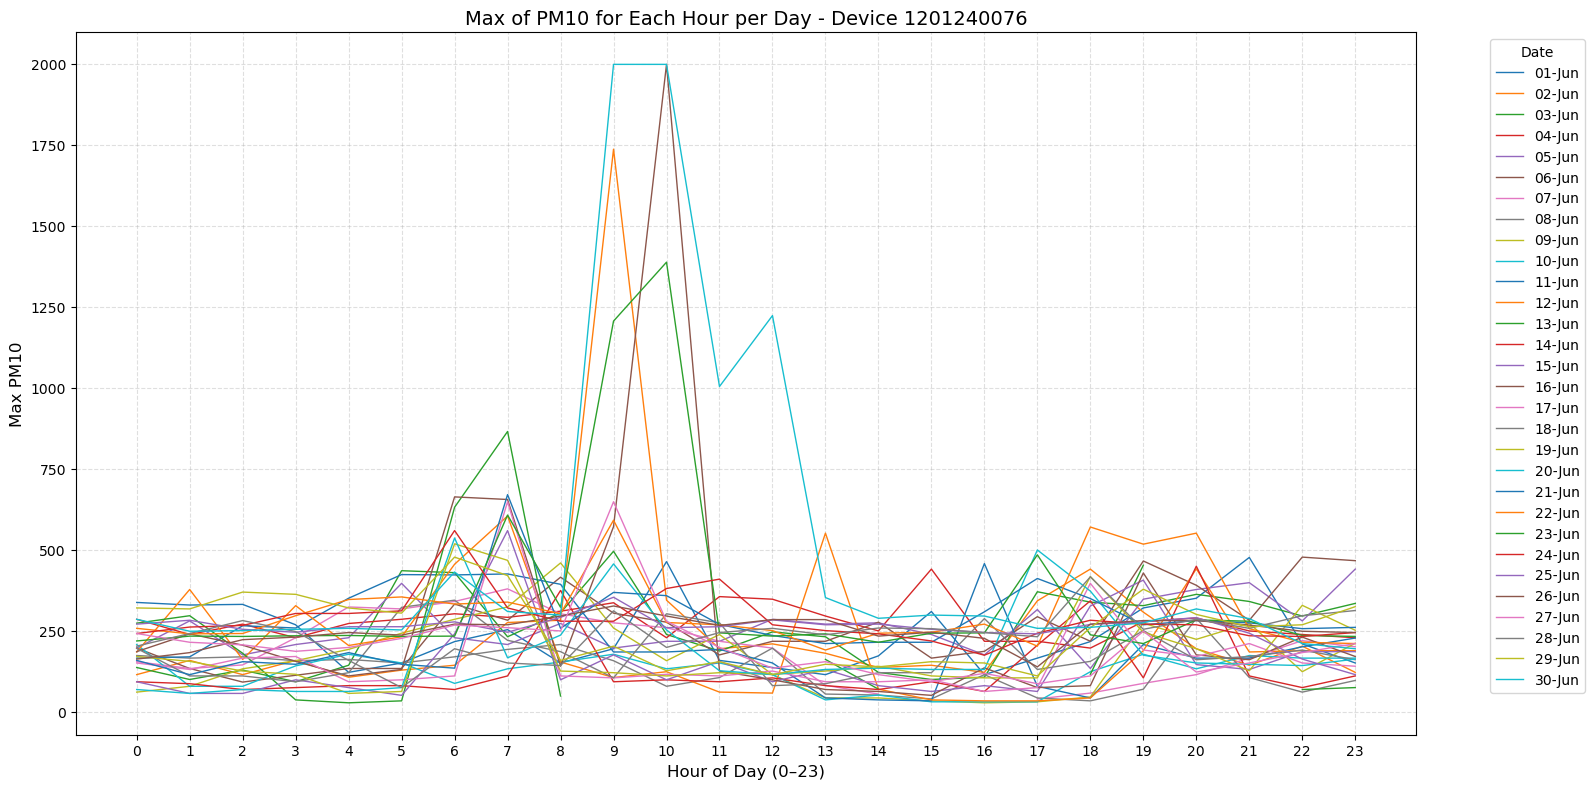


Generating Line Charts for Device 1201240079


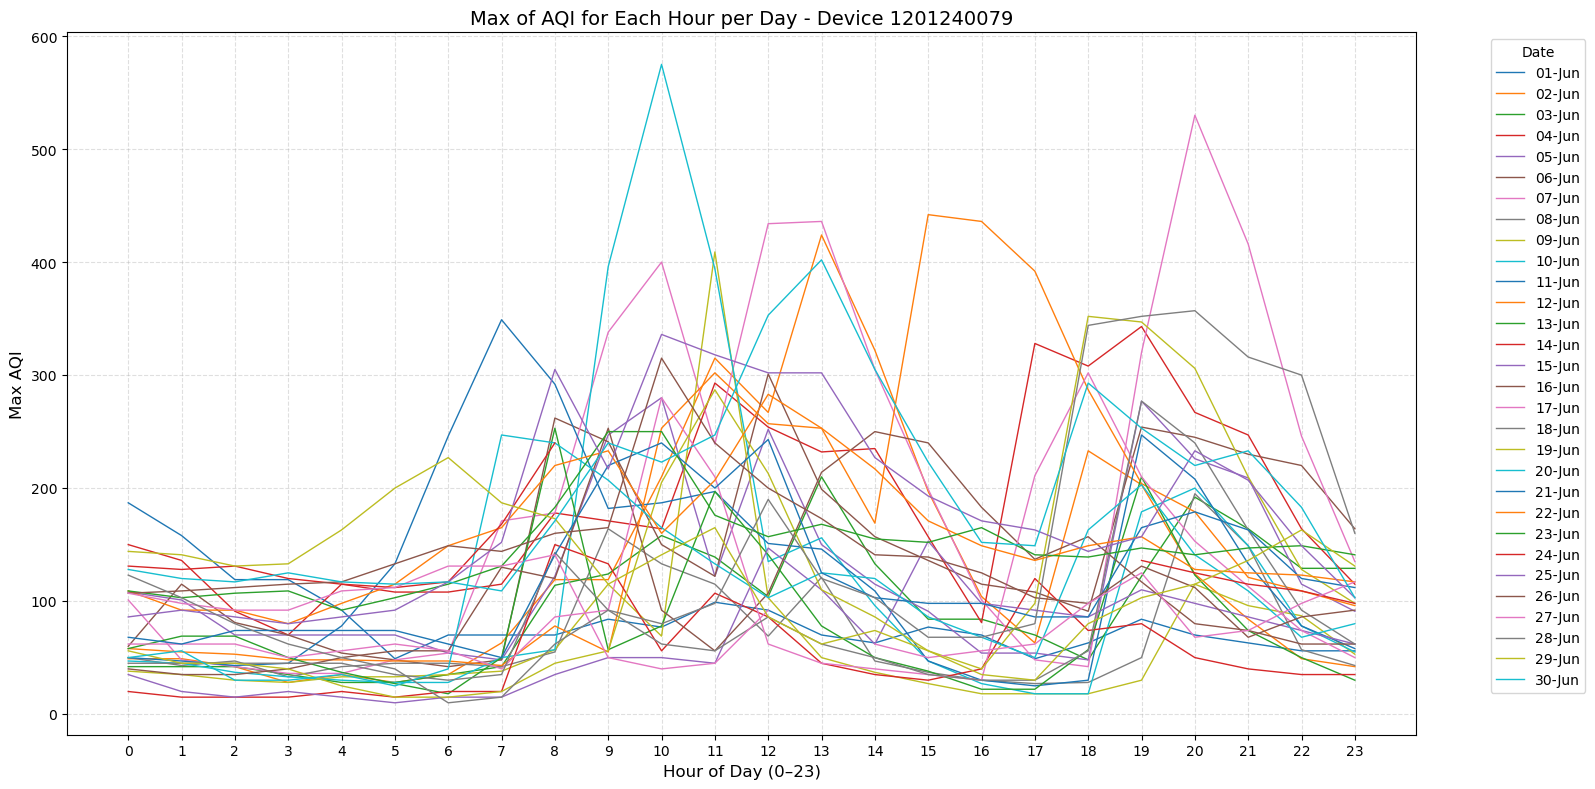

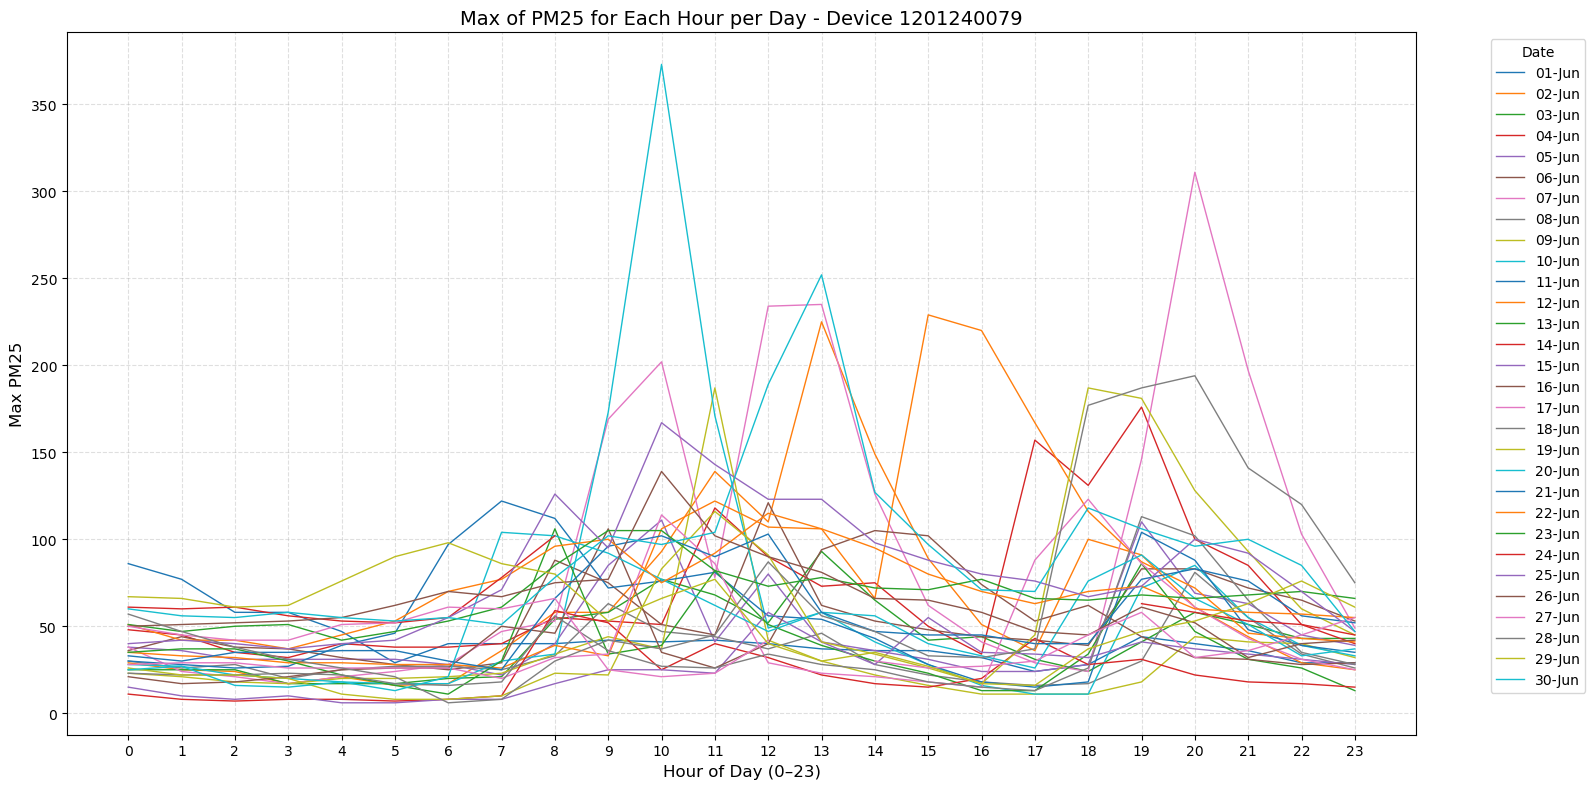

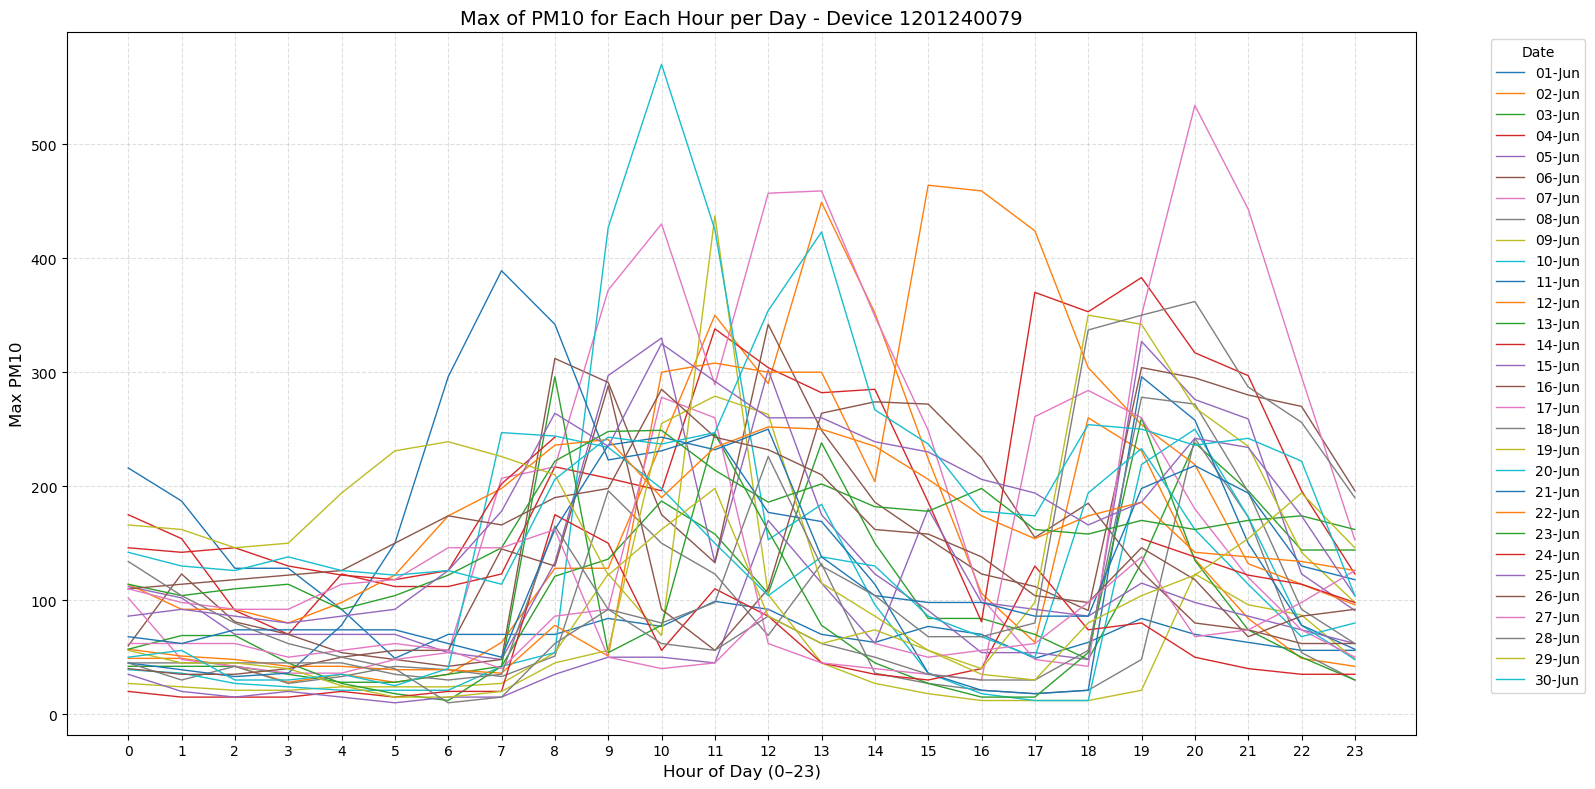

In [85]:
pollutants = ['aqi', 'pm25', 'pm10']

def plot_indoor_vs_outdoor_scatter(indoor_device_id, outdoor_device_id, year, month, time_intervals):
    """
    Create scatter plots comparing indoor vs outdoor pollutant values, 
    color-coded by user-defined time intervals.
    
    time_intervals: list of (start_hour, end_hour) tuples
    """
    try:
        conn = mysql.connector.connect(**DB_CONFIG)
        cursor = conn.cursor()

        # Get outdoor data first
        outdoor_query = """
            SELECT datetime, pm25, pm10, aqi
            FROM cpcb_data
            WHERE deviceID = %s AND YEAR(datetime) = %s AND MONTH(datetime) = %s;
        """
        cursor.execute(outdoor_query, (outdoor_device_id, year, month))
        outdoor_data = cursor.fetchall()
        outdoor_df = pd.DataFrame(outdoor_data, columns=['datetime', 'pm25_outdoor', 'pm10_outdoor', 'aqi_outdoor'])
        outdoor_df['datetime'] = pd.to_datetime(outdoor_df['datetime'])
        outdoor_df = outdoor_df[(outdoor_df[['aqi_outdoor', 'pm25_outdoor', 'pm10_outdoor']] != 0).all(axis=1)]
        
        if outdoor_df.empty:
            print("No outdoor data available.")
            return

        # Extract date and hour for grouping
        outdoor_df['date_hour'] = outdoor_df['datetime'].dt.strftime('%Y-%m-%d %H:00:00')
        outdoor_df['hour'] = outdoor_df['datetime'].dt.hour
        # Calculate hourly averages for each day for outdoor data
        outdoor_hourly = outdoor_df.groupby('date_hour').agg({
            'pm25_outdoor': 'mean',
            'pm10_outdoor': 'mean',
            'aqi_outdoor': 'mean',
            'hour': 'first'  # Keep the hour information
        }).reset_index()
        
        # Get indoor data for the same time range
        min_date = outdoor_df['datetime'].min().strftime('%Y-%m-%d %H:%M:%S')
        max_date = outdoor_df['datetime'].max().strftime('%Y-%m-%d %H:%M:%S')
        
        indoor_query = f"""
            SELECT datetime, aqi, pm25, pm10
            FROM reading_db
            WHERE deviceID = %s 
            AND datetime >= %s 
            AND datetime <= %s;
        """
        cursor.execute(indoor_query, (indoor_device_id, min_date, max_date))
        indoor_data = cursor.fetchall()
        indoor_df = pd.DataFrame(indoor_data, columns=['datetime', 'aqi_indoor', 'pm25_indoor', 'pm10_indoor'])
        indoor_df['datetime'] = pd.to_datetime(indoor_df['datetime'])
        indoor_df = indoor_df[(indoor_df[['aqi_indoor', 'pm25_indoor', 'pm10_indoor']] != 0).all(axis=1)]
        
        # Extract date and hour for grouping
        indoor_df['date_hour'] = indoor_df['datetime'].dt.strftime('%Y-%m-%d %H:00:00')
        indoor_df = indoor_df.dropna()
        # Calculate hourly averages for each day for indoor data
        indoor_hourly = indoor_df.groupby('date_hour').agg({
            'pm25_indoor': 'mean',
            'pm10_indoor': 'mean',
            'aqi_indoor': 'mean'
        }).reset_index()
        
        # Merge hourly data
        merged_df = pd.merge(outdoor_hourly, indoor_hourly, on='date_hour', how='left')
        merged_df['datetime'] = pd.to_datetime(merged_df['date_hour'])
        
        # Remove rows where indoor data is missing
        merged_df = merged_df.dropna()

        if merged_df.empty:
            print("No matching indoor and outdoor data available.")
            return

        def classify_interval(hour):
            for idx, (start, end) in enumerate(time_intervals):
                if start <= hour < end:
                    return f"Interval {idx+1} ({start}-{end})"
            return "Other Times"

        merged_df['time_label'] = merged_df['hour'].apply(classify_interval)

        # Plot
        pollutants = ['aqi', 'pm25', 'pm10']
        plt.figure(figsize=(18, 5))

        # Simplify time labels
        merged_df['simplified_label'] = merged_df['time_label'].apply(
            lambda x: 'Time Intervals' if 'Interval' in x else 'Other Times'
        )

        # Save the data with datetime information
        # merged_df.to_csv('testing_1201240074.csv', index=False)
        
        colors = {
            'Time Intervals': 'blue',
            'Other Times': 'orange'
        }

        for i, pollutant in enumerate(pollutants):
            plt.subplot(1, 3, i + 1)
            sns.scatterplot(
                data=merged_df,
                y=f'{pollutant}_outdoor',
                x=f'{pollutant}_indoor',
                hue='simplified_label',
                palette=colors,
                alpha=0.7,
                edgecolor='k'
            )
            plt.xlabel(f'Outdoor {pollutant.upper()} (Hourly Avg)')
            plt.ylabel(f'Indoor {pollutant.upper()} (Hourly Avg)')
            plt.title(f'Indoor vs Outdoor {pollutant.upper()}\nHourly Averages for {month}/{year}')
            plt.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        # filename = f'indoor_vs_outdoor_hourly_monthly_{indoor_device_id}_{outdoor_device_id}_{month}_{year}.png'
        # plt.savefig(filename, dpi=300)
        plt.show()
        # print(f"Saved hourly average scatter plot as: {filename}")

    except mysql.connector.Error as err:
        print(f"Database error: {err}")

    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()
        
if __name__ == '__main__':
    print("Pollutant Data Visualization")
    print("Enter 3 Device IDs:")
    device_ids = []
    for i in range(3):
        device = input(f"Enter Device ID #{i+1}: ")
        device_ids.append(device)
    
    year = int(input("Enter Year (e.g., 2024): "))
    month = int(input("Enter Month (1–12): "))
    print("\nChoose Visualization Type:")
    print("1 - Box Plot (hourly distribution)")
    print("2 - Line Chart (max per hour per day, for all pollutants)")
    print("3 - Scatter Plot (Indoor vs Outdoor)")

    choice = input("Enter your choice (1, 2 or 3): ")
    
    if choice == '1':
        for device_id in device_ids:
            print(f"\nGenerating Box Plot for Device {device_id}")
            plot_pollutant_boxplots(device_id, year, month)
    
    elif choice == '2':
        for device_id in device_ids:
            print(f"\nGenerating Line Charts for Device {device_id}")
            for pollutant in pollutants:
                plot_daily_hourly_max_pollutant(device_id, year, month, pollutant)
    
    elif choice == '3':
        print("\nFor Scatter Plots, need Indoor-Outdoor device pairs:")
        device_pairs = []
        for i in range(3):
            indoor_id = input(f"Enter Indoor Device ID #{i+1}: ")
            outdoor_id = input(f"Enter corresponding Outdoor Device ID #{i+1}: ")
            device_pairs.append((indoor_id, outdoor_id))
        
        print("Enter time intervals (e.g., 7-9,12-13,20-21):")
        intervals_input = input("Time intervals: ")
        time_intervals = []
        for part in intervals_input.split(','):
            start, end = map(int, part.split('-'))
            time_intervals.append((start, end))
        
        for indoor_id, outdoor_id in device_pairs:
            print(f"\nGenerating comparison for Indoor Device {indoor_id} vs Outdoor Device {outdoor_id}")
            plot_indoor_vs_outdoor_scatter(indoor_id, outdoor_id, year, month, time_intervals)
    
    else:
        print("Invalid choice. Please enter 1, 2, or 3.")


### Indoor vs Outdoor for all Device IDs 


PM2.5 Analysis for Month 8/2024
Total hours analyzed: 377
Hours where indoor PM2.5 > outdoor PM2.5: 88 (23.34%)
Hours where outdoor PM2.5 > indoor PM2.5: 289 (76.66%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 3018
Hours where indoor PM2.5 > outdoor PM2.5: 692 (22.93%)
Hours where outdoor PM2.5 > indoor PM2.5: 2326 (77.07%)


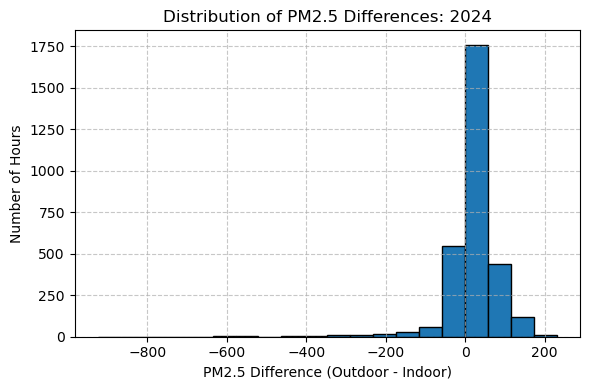

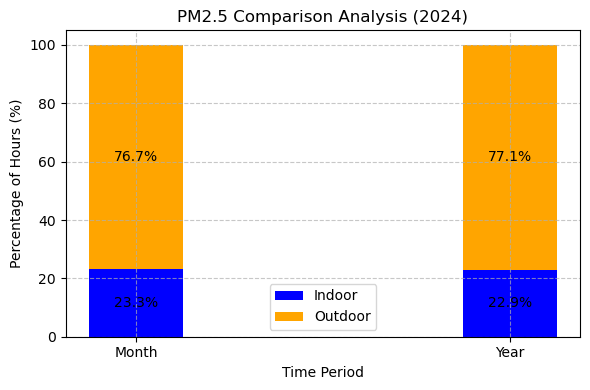

In [19]:

def analyze_indoor_outdoor_pm25(indoor_device_id, outdoor_device_id, year, month):
    try:
        conn = mysql.connector.connect(**DB_CONFIG)
        cursor = conn.cursor()

        # Get outdoor data for the entire year
        outdoor_year_query = """
            SELECT datetime, pm25
            FROM cpcb_data
            WHERE deviceID = %s AND YEAR(datetime) = %s;
        """
        cursor.execute(outdoor_year_query, (outdoor_device_id, year))
        outdoor_year_data = cursor.fetchall()
        outdoor_year_df = pd.DataFrame(outdoor_year_data, columns=['datetime', 'pm25_outdoor'])
        outdoor_year_df['datetime'] = pd.to_datetime(outdoor_year_df['datetime'])
        outdoor_year_df = outdoor_year_df[outdoor_year_df['pm25_outdoor'] != 0]
        
        # Get indoor data for the entire year
        indoor_year_query = """
            SELECT datetime, pm25
            FROM reading_db
            WHERE deviceID = %s 
            AND YEAR(datetime) = %s;
        """
        cursor.execute(indoor_year_query, (indoor_device_id, year))
        indoor_year_data = cursor.fetchall()
        indoor_year_df = pd.DataFrame(indoor_year_data, columns=['datetime', 'pm25_indoor'])
        indoor_year_df['datetime'] = pd.to_datetime(indoor_year_df['datetime'])
        indoor_year_df = indoor_year_df[indoor_year_df['pm25_indoor'] != 0]
        
        # Process year data
        outdoor_year_df['date_hour'] = outdoor_year_df['datetime'].dt.strftime('%Y-%m-%d %H:00:00')
        indoor_year_df['date_hour'] = indoor_year_df['datetime'].dt.strftime('%Y-%m-%d %H:00:00')
        
        # Calculate hourly averages for year data
        outdoor_year_hourly = outdoor_year_df.groupby('date_hour')['pm25_outdoor'].mean().reset_index()
        indoor_year_hourly = indoor_year_df.groupby('date_hour')['pm25_indoor'].mean().reset_index()
        
        # Merge year data
        merged_year_df = pd.merge(outdoor_year_hourly, indoor_year_hourly, on='date_hour', how='inner')
        merged_year_df['datetime'] = pd.to_datetime(merged_year_df['date_hour'])
        # merged_year_df.to_csv('yearly_data_1201240074.csv')
        
        # Filter month data from the year data
        merged_month_df = merged_year_df[merged_year_df['datetime'].dt.month == month].copy()  # Create explicit copy
        
        # Create lists to store data for plotting
        periods = ['Month', 'Year']
        indoor_higher_pct = []
        outdoor_higher_pct = []
        
        # Analysis for the month
        if not merged_month_df.empty:
            total_month_hours = len(merged_month_df)
            month_indoor_higher = len(merged_month_df[merged_month_df['pm25_indoor'] > merged_month_df['pm25_outdoor']])
            month_outdoor_higher = total_month_hours - month_indoor_higher
            month_indoor_pct = (month_indoor_higher / total_month_hours) * 100
            month_outdoor_pct = (month_outdoor_higher / total_month_hours) * 100
            
            indoor_higher_pct.append(month_indoor_pct)
            outdoor_higher_pct.append(month_outdoor_pct)
            
            print(f"\nPM2.5 Analysis for Month {month}/{year}")
            print(f"Total hours analyzed: {total_month_hours}")
            print(f"Hours where indoor PM2.5 > outdoor PM2.5: {month_indoor_higher} ({month_indoor_pct:.2f}%)")
            print(f"Hours where outdoor PM2.5 > indoor PM2.5: {month_outdoor_higher} ({month_outdoor_pct:.2f}%)")
        else:
            print(f"\nNo data available for Month {month}/{year}")
            indoor_higher_pct.append(0)
            outdoor_higher_pct.append(0)
        
        # Analysis for the year
        if not merged_year_df.empty:
            total_year_hours = len(merged_year_df)
            year_indoor_higher = len(merged_year_df[merged_year_df['pm25_indoor'] > merged_year_df['pm25_outdoor']])
            year_outdoor_higher = total_year_hours - year_indoor_higher
            year_indoor_pct = (year_indoor_higher / total_year_hours) * 100
            year_outdoor_pct = (year_outdoor_higher / total_year_hours) * 100
            
            indoor_higher_pct.append(year_indoor_pct)
            outdoor_higher_pct.append(year_outdoor_pct)
            
            print(f"\nPM2.5 Analysis for Year {year}")
            print(f"Total hours analyzed: {total_year_hours}")
            print(f"Hours where indoor PM2.5 > outdoor PM2.5: {year_indoor_higher} ({year_indoor_pct:.2f}%)")
            print(f"Hours where outdoor PM2.5 > indoor PM2.5: {year_outdoor_higher} ({year_outdoor_pct:.2f}%)")
        else:
            print(f"\nNo data available for Year {year}")
            indoor_higher_pct.append(0)
            outdoor_higher_pct.append(0)

        # Create lists to store data for plotting
        periods = ['Month', 'Year']
        indoor_higher_pct = []
        outdoor_higher_pct = []
        
        # Analysis for the month
        if not merged_month_df.empty:
            total_month_hours = len(merged_month_df)
            month_indoor_higher = len(merged_month_df[merged_month_df['pm25_indoor'] > merged_month_df['pm25_outdoor']])
            month_outdoor_higher = total_month_hours - month_indoor_higher
            month_indoor_pct = (month_indoor_higher / total_month_hours) * 100
            month_outdoor_pct = (month_outdoor_higher / total_month_hours) * 100
            
            indoor_higher_pct.append(month_indoor_pct)
            outdoor_higher_pct.append(month_outdoor_pct)
            
            # print(f"\nPM2.5 Analysis for Month {month}/{year}")
            # print(f"Total hours analyzed: {total_month_hours}")
            # print(f"Hours where indoor PM2.5 > outdoor PM2.5: {month_indoor_higher} ({month_indoor_pct:.2f}%)")
            # print(f"Hours where outdoor PM2.5 > indoor PM2.5: {month_outdoor_higher} ({month_outdoor_pct:.2f}%)")
        else:
            print(f"\nNo data available for Month {month}/{year}")
            indoor_higher_pct.append(0)
            outdoor_higher_pct.append(0)
        
        # Analysis for the year
        if not merged_year_df.empty:
            total_year_hours = len(merged_year_df)
            year_indoor_higher = len(merged_year_df[merged_year_df['pm25_indoor'] > merged_year_df['pm25_outdoor']])
            year_outdoor_higher = total_year_hours - year_indoor_higher
            year_indoor_pct = (year_indoor_higher / total_year_hours) * 100
            year_outdoor_pct = (year_outdoor_higher / total_year_hours) * 100
            
            indoor_higher_pct.append(year_indoor_pct)
            outdoor_higher_pct.append(year_outdoor_pct)
            
            # print(f"\nPM2.5 Analysis for Year {year}")
            # print(f"Total hours analyzed: {total_year_hours}")
            # print(f"Hours where indoor PM2.5 > outdoor PM2.5: {year_indoor_higher} ({year_indoor_pct:.2f}%)")
            # print(f"Hours where outdoor PM2.5 > indoor PM2.5: {year_outdoor_higher} ({year_outdoor_pct:.2f}%)")
        else:
            print(f"\nNo data available for Year {year}")
            indoor_higher_pct.append(0)
            outdoor_higher_pct.append(0)

        

        # Calculate differences for histogram - now using copy of DataFrame
        merged_year_df.loc[:, 'pm25_difference'] = merged_year_df['pm25_outdoor'] - merged_year_df['pm25_indoor']
        # merged_year_df.to_csv('with_difference.csv')
        # Create histogram for month data
        plt.figure(figsize=(6, 4))
        plt.hist(merged_year_df['pm25_difference'], bins=20, edgecolor='black')
        plt.xlabel('PM2.5 Difference (Outdoor - Indoor)')
        plt.ylabel('Number of Hours')
        plt.title(f'Distribution of PM2.5 Differences: {year}')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        # hist_filename = f'pm25_difference_hist_{indoor_device_id}_{outdoor_device_id}_{year}_{month}.png'
        # plt.savefig(hist_filename, dpi=300)
        plt.show()

        # Create stacked bar chart
        plt.figure(figsize=(6, 4))  
        x = np.arange(len(periods))
        width = 0.25 
        
        # Create stacked bars
        plt.bar(x, indoor_higher_pct, width ,label='Indoor', color='blue')
        plt.bar(x, outdoor_higher_pct, width , bottom=indoor_higher_pct, label='Outdoor', color='orange')

        plt.xlabel('Time Period')
        plt.ylabel('Percentage of Hours (%)')
        plt.title(f'PM2.5 Comparison Analysis ({year})')
        plt.xticks(x, periods)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add percentage labels on the bars
        for i in range(len(periods)):
            # Label for indoor (bottom) percentage
            plt.text(i, indoor_higher_pct[i]/2, f'{indoor_higher_pct[i]:.1f}%', 
                    ha='center', va='center')
            # Label for outdoor (top) percentage
            plt.text(i, indoor_higher_pct[i] + outdoor_higher_pct[i]/2, 
                    f'{outdoor_higher_pct[i]:.1f}%', ha='center', va='center')

        plt.tight_layout()
        # filename = f'pm25_comparison_{indoor_device_id}_{outdoor_device_id}_{year}.png'
        # plt.savefig(filename, dpi=300)
        plt.show()

    except mysql.connector.Error as err:
        print(f"Database error: {err}")

    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()

analyze_indoor_outdoor_pm25(1201240074, "DELCPCB005", 2024, 8)


Analyzing device pair: Indoor 1202240011 - Outdoor DELCPCB010

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 70
Hours where indoor PM2.5 > outdoor PM2.5: 30 (42.86%)
Hours where outdoor PM2.5 > indoor PM2.5: 40 (57.14%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 993
Hours where indoor PM2.5 > outdoor PM2.5: 368 (37.06%)
Hours where outdoor PM2.5 > indoor PM2.5: 625 (62.94%)


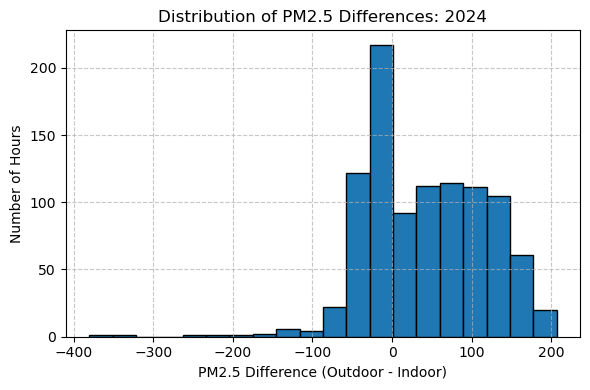

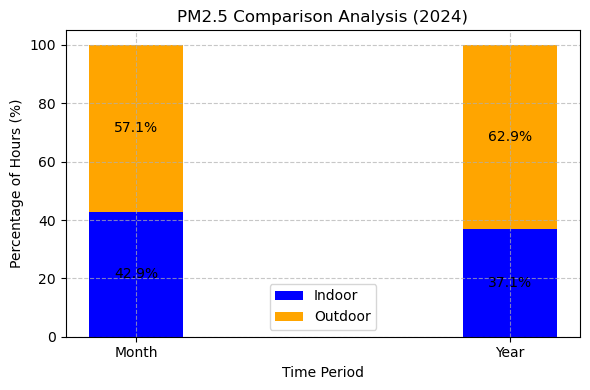


Analyzing device pair: Indoor 1201240073 - Outdoor DELDPCC018

No data available for Month 8/2024

PM2.5 Analysis for Year 2024
Total hours analyzed: 184
Hours where indoor PM2.5 > outdoor PM2.5: 105 (57.07%)
Hours where outdoor PM2.5 > indoor PM2.5: 79 (42.93%)

No data available for Month 8/2024


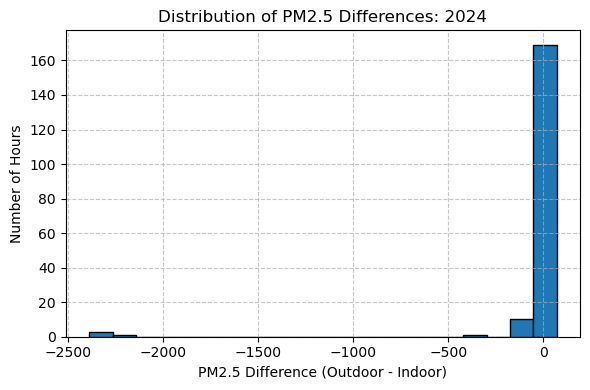

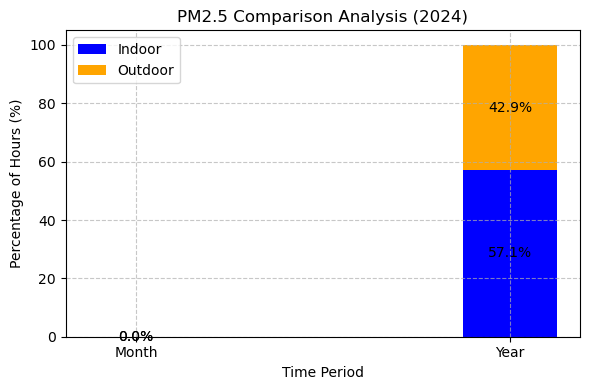


Analyzing device pair: Indoor 1202240027 - Outdoor DELCPCB010

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 78
Hours where indoor PM2.5 > outdoor PM2.5: 27 (34.62%)
Hours where outdoor PM2.5 > indoor PM2.5: 51 (65.38%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 1001
Hours where indoor PM2.5 > outdoor PM2.5: 526 (52.55%)
Hours where outdoor PM2.5 > indoor PM2.5: 475 (47.45%)


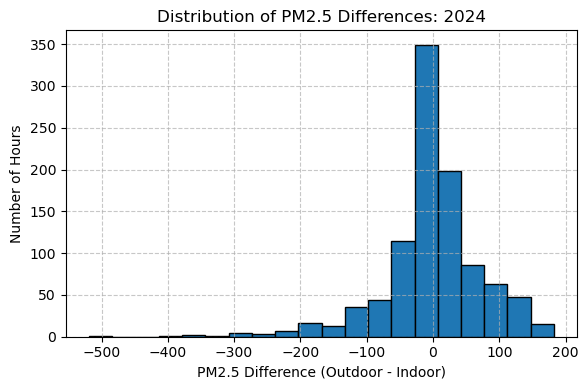

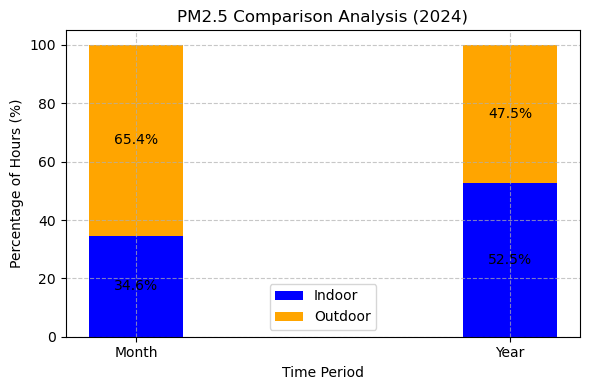


Analyzing device pair: Indoor 1202240029 - Outdoor DELDPCC016

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 183
Hours where indoor PM2.5 > outdoor PM2.5: 58 (31.69%)
Hours where outdoor PM2.5 > indoor PM2.5: 125 (68.31%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 4505
Hours where indoor PM2.5 > outdoor PM2.5: 2737 (60.75%)
Hours where outdoor PM2.5 > indoor PM2.5: 1768 (39.25%)


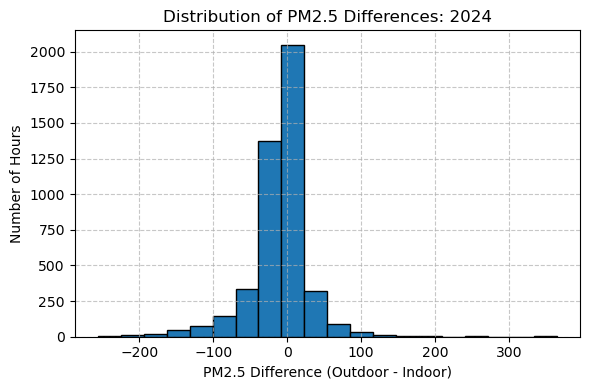

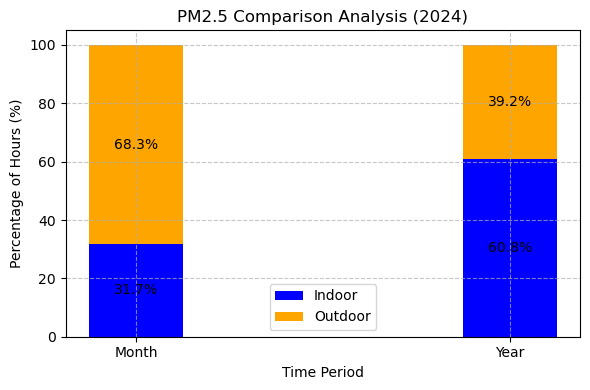


Analyzing device pair: Indoor 1202240026 - Outdoor THIRD_DPCC_SCR_RKPURAM

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 685
Hours where indoor PM2.5 > outdoor PM2.5: 95 (13.87%)
Hours where outdoor PM2.5 > indoor PM2.5: 590 (86.13%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 4804
Hours where indoor PM2.5 > outdoor PM2.5: 1380 (28.73%)
Hours where outdoor PM2.5 > indoor PM2.5: 3424 (71.27%)


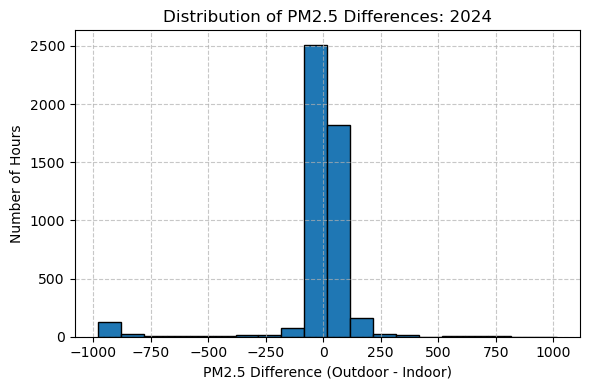

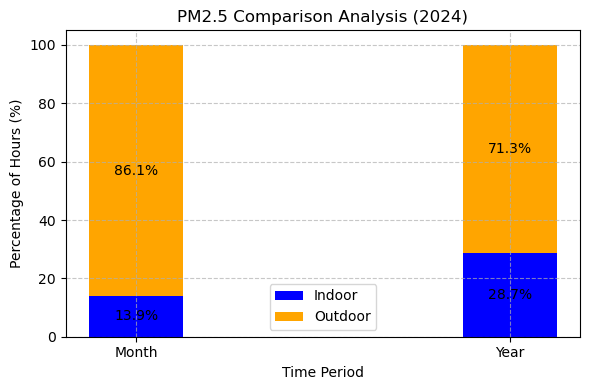


Analyzing device pair: Indoor 1202240028 - Outdoor DELDPCC016

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 216
Hours where indoor PM2.5 > outdoor PM2.5: 60 (27.78%)
Hours where outdoor PM2.5 > indoor PM2.5: 156 (72.22%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 4823
Hours where indoor PM2.5 > outdoor PM2.5: 2301 (47.71%)
Hours where outdoor PM2.5 > indoor PM2.5: 2522 (52.29%)


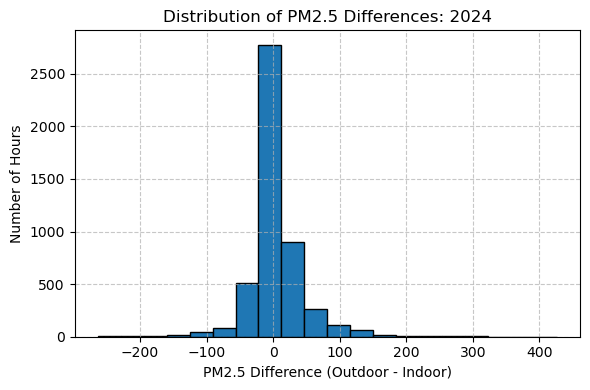

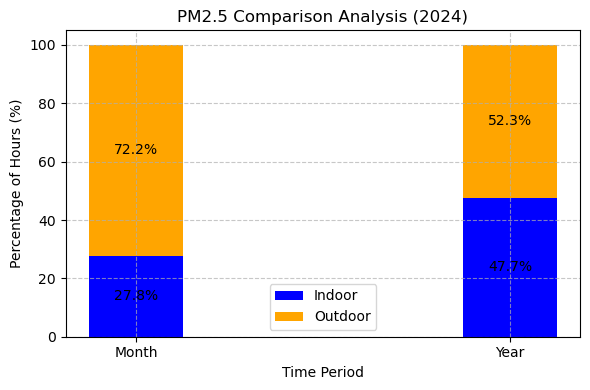


Analyzing device pair: Indoor 1202240012 - Outdoor DELDPCC016

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 87
Hours where indoor PM2.5 > outdoor PM2.5: 58 (66.67%)
Hours where outdoor PM2.5 > indoor PM2.5: 29 (33.33%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 4254
Hours where indoor PM2.5 > outdoor PM2.5: 2563 (60.25%)
Hours where outdoor PM2.5 > indoor PM2.5: 1691 (39.75%)


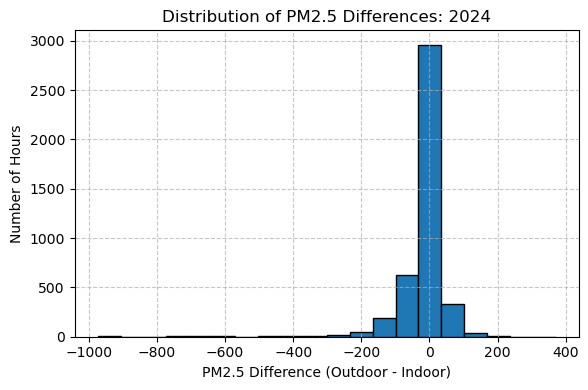

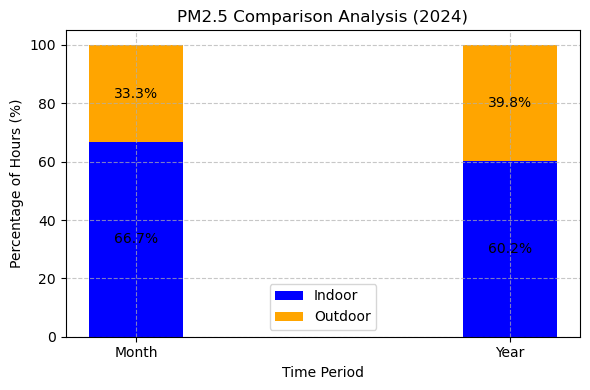


Analyzing device pair: Indoor 1202240010 - Outdoor DELDPCC016

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 247
Hours where indoor PM2.5 > outdoor PM2.5: 37 (14.98%)
Hours where outdoor PM2.5 > indoor PM2.5: 210 (85.02%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 4654
Hours where indoor PM2.5 > outdoor PM2.5: 2246 (48.26%)
Hours where outdoor PM2.5 > indoor PM2.5: 2408 (51.74%)


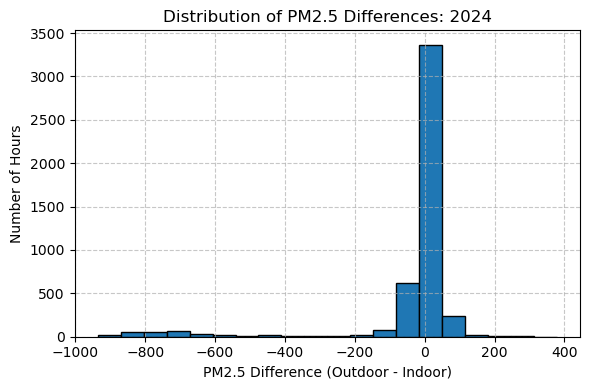

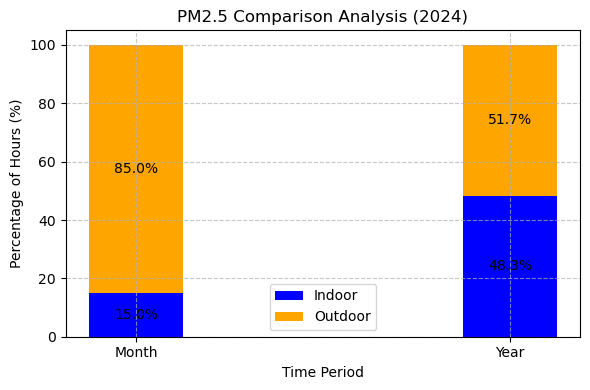


Analyzing device pair: Indoor 1201240075 - Outdoor CPCB1703205345

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 636
Hours where indoor PM2.5 > outdoor PM2.5: 90 (14.15%)
Hours where outdoor PM2.5 > indoor PM2.5: 546 (85.85%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 3776
Hours where indoor PM2.5 > outdoor PM2.5: 647 (17.13%)
Hours where outdoor PM2.5 > indoor PM2.5: 3129 (82.87%)


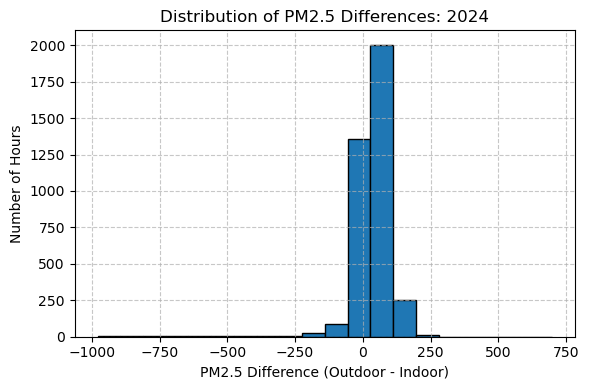

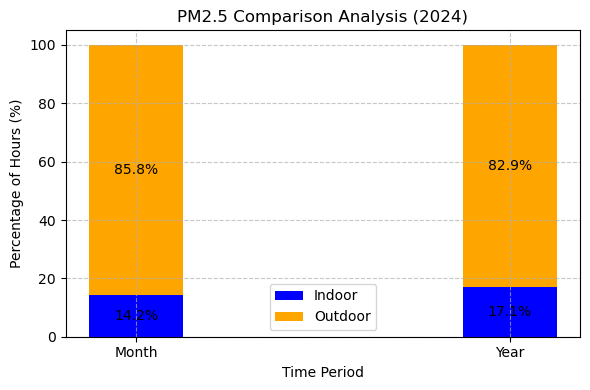

No outdoor device mapping found for indoor device 1201240078

Analyzing device pair: Indoor 1202240025 - Outdoor THIRD_DPCC_SCR_RKPURAM

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 685
Hours where indoor PM2.5 > outdoor PM2.5: 89 (12.99%)
Hours where outdoor PM2.5 > indoor PM2.5: 596 (87.01%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 4871
Hours where indoor PM2.5 > outdoor PM2.5: 1286 (26.40%)
Hours where outdoor PM2.5 > indoor PM2.5: 3585 (73.60%)


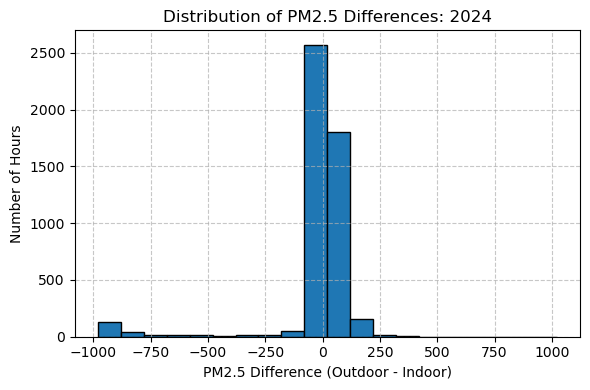

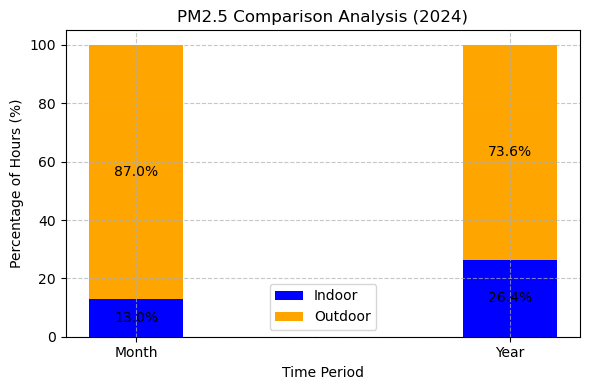


Analyzing device pair: Indoor 1201240077 - Outdoor DELDPCC016

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 369
Hours where indoor PM2.5 > outdoor PM2.5: 29 (7.86%)
Hours where outdoor PM2.5 > indoor PM2.5: 340 (92.14%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 3226
Hours where indoor PM2.5 > outdoor PM2.5: 736 (22.81%)
Hours where outdoor PM2.5 > indoor PM2.5: 2490 (77.19%)


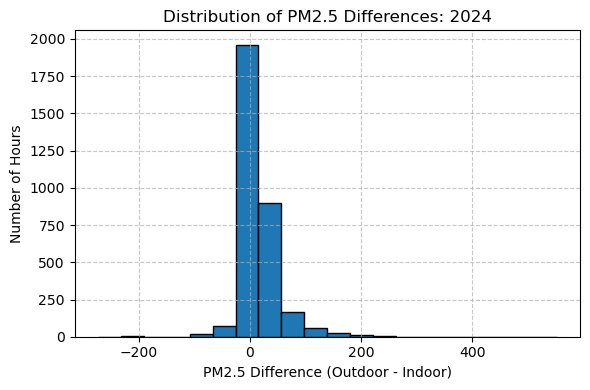

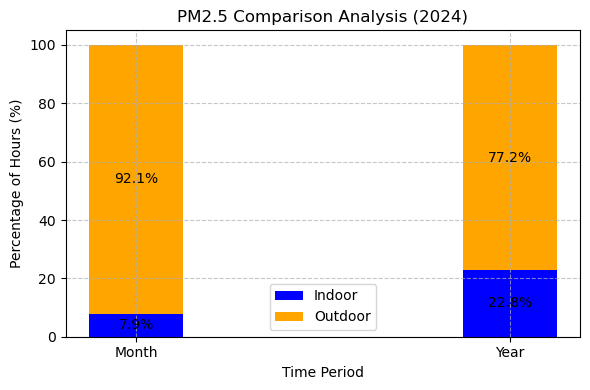


Analyzing device pair: Indoor 1201240079 - Outdoor DELDPCC006

No data available for Month 8/2024

PM2.5 Analysis for Year 2024
Total hours analyzed: 1961
Hours where indoor PM2.5 > outdoor PM2.5: 889 (45.33%)
Hours where outdoor PM2.5 > indoor PM2.5: 1072 (54.67%)

No data available for Month 8/2024


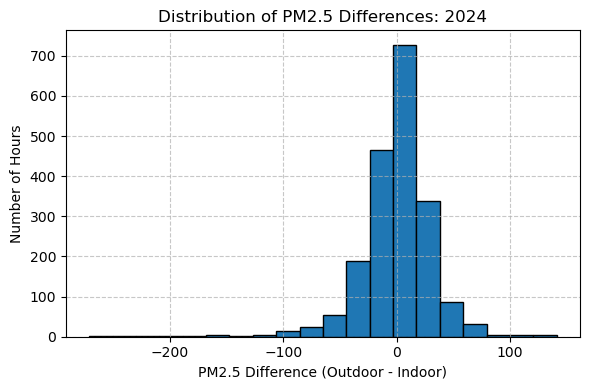

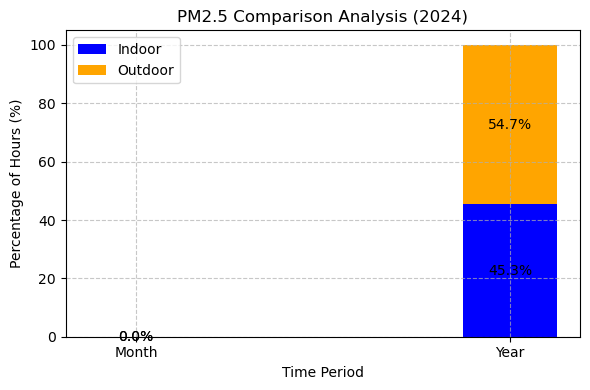


Analyzing device pair: Indoor 1201240085 - Outdoor DELDPCC006

No data available for Month 8/2024

PM2.5 Analysis for Year 2024
Total hours analyzed: 7
Hours where indoor PM2.5 > outdoor PM2.5: 4 (57.14%)
Hours where outdoor PM2.5 > indoor PM2.5: 3 (42.86%)

No data available for Month 8/2024


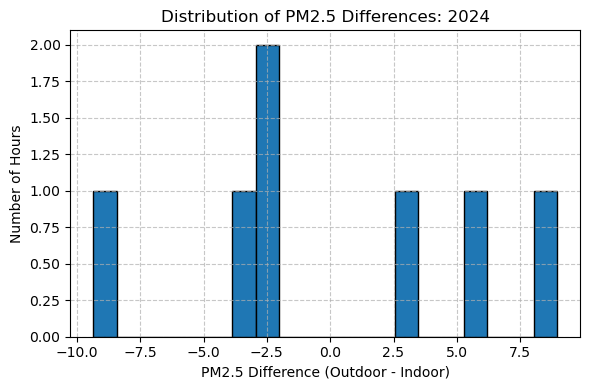

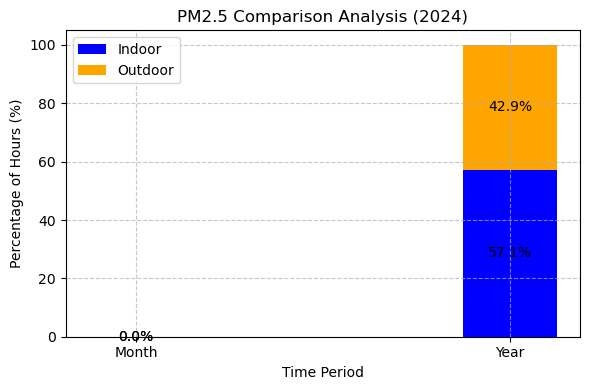


Analyzing device pair: Indoor 1201240076 - Outdoor DELDPCC018

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 658
Hours where indoor PM2.5 > outdoor PM2.5: 507 (77.05%)
Hours where outdoor PM2.5 > indoor PM2.5: 151 (22.95%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 5129
Hours where indoor PM2.5 > outdoor PM2.5: 4097 (79.88%)
Hours where outdoor PM2.5 > indoor PM2.5: 1032 (20.12%)


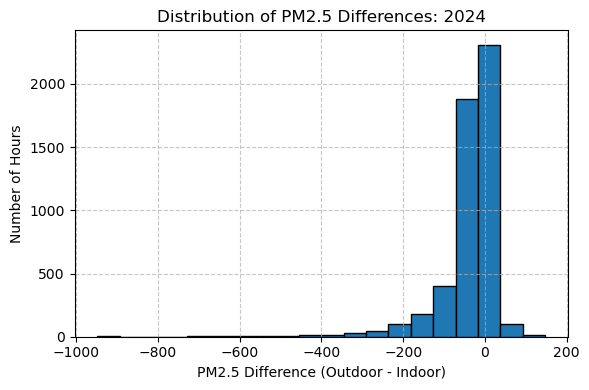

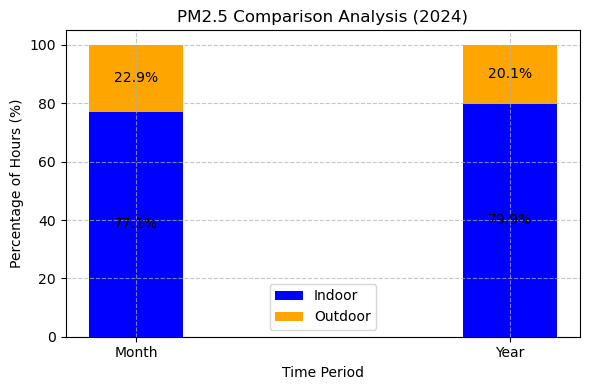


Analyzing device pair: Indoor 1212230160 - Outdoor DELDPCC018

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 638
Hours where indoor PM2.5 > outdoor PM2.5: 277 (43.42%)
Hours where outdoor PM2.5 > indoor PM2.5: 361 (56.58%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 5147
Hours where indoor PM2.5 > outdoor PM2.5: 3453 (67.09%)
Hours where outdoor PM2.5 > indoor PM2.5: 1694 (32.91%)


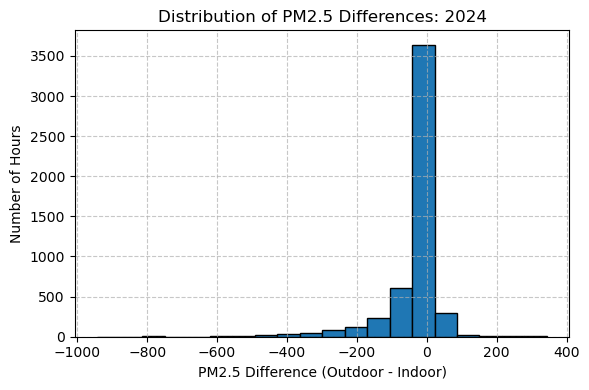

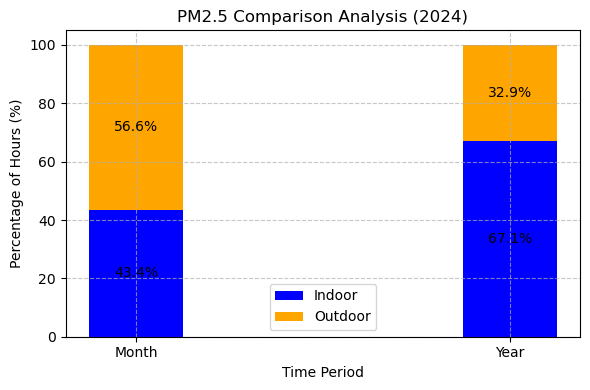


Analyzing device pair: Indoor 1202240009 - Outdoor DELDPCC018

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 548
Hours where indoor PM2.5 > outdoor PM2.5: 256 (46.72%)
Hours where outdoor PM2.5 > indoor PM2.5: 292 (53.28%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 5100
Hours where indoor PM2.5 > outdoor PM2.5: 2703 (53.00%)
Hours where outdoor PM2.5 > indoor PM2.5: 2397 (47.00%)


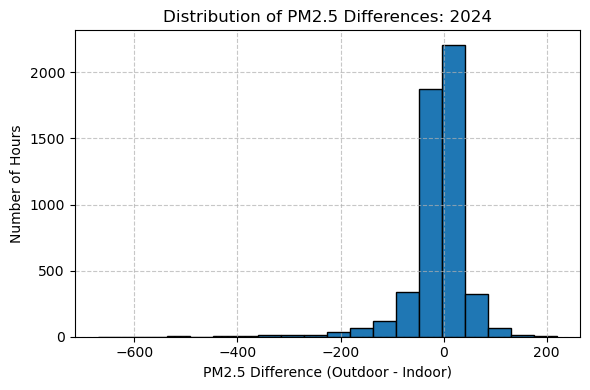

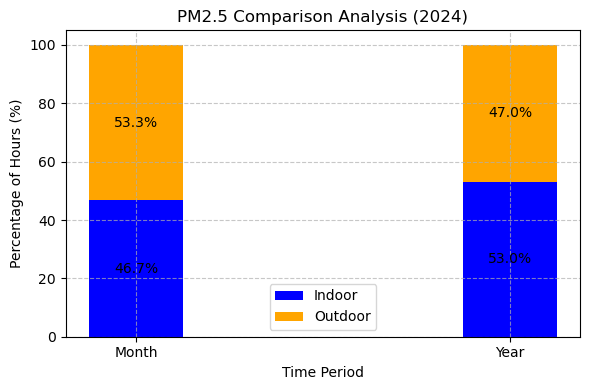


Analyzing device pair: Indoor 1202240008 - Outdoor DELDPCC018

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 186
Hours where indoor PM2.5 > outdoor PM2.5: 108 (58.06%)
Hours where outdoor PM2.5 > indoor PM2.5: 78 (41.94%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 4233
Hours where indoor PM2.5 > outdoor PM2.5: 2566 (60.62%)
Hours where outdoor PM2.5 > indoor PM2.5: 1667 (39.38%)


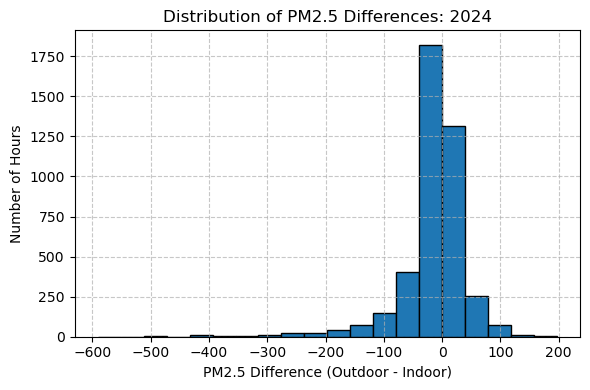

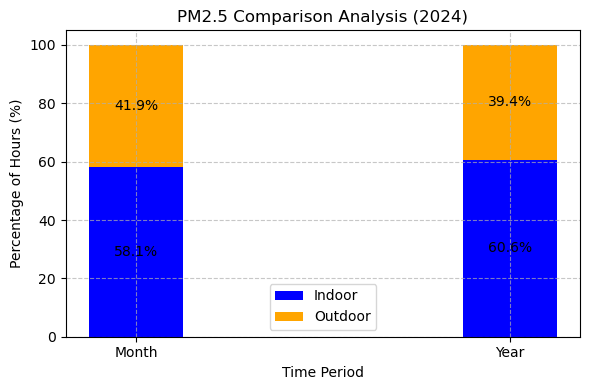


Analyzing device pair: Indoor 1201240074 - Outdoor DELCPCB005

PM2.5 Analysis for Month 8/2024
Total hours analyzed: 377
Hours where indoor PM2.5 > outdoor PM2.5: 88 (23.34%)
Hours where outdoor PM2.5 > indoor PM2.5: 289 (76.66%)

PM2.5 Analysis for Year 2024
Total hours analyzed: 3018
Hours where indoor PM2.5 > outdoor PM2.5: 692 (22.93%)
Hours where outdoor PM2.5 > indoor PM2.5: 2326 (77.07%)


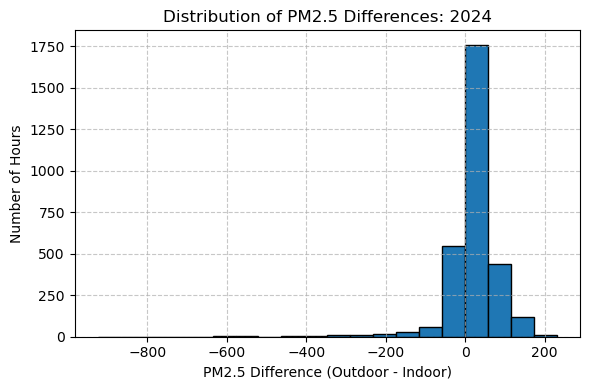

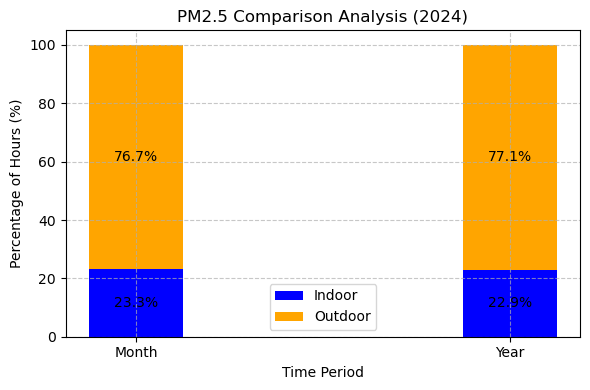


Analyzing device pair: Indoor 1203240080 - Outdoor DELCPCB005

No data available for Month 8/2024

PM2.5 Analysis for Year 2024
Total hours analyzed: 847
Hours where indoor PM2.5 > outdoor PM2.5: 101 (11.92%)
Hours where outdoor PM2.5 > indoor PM2.5: 746 (88.08%)

No data available for Month 8/2024


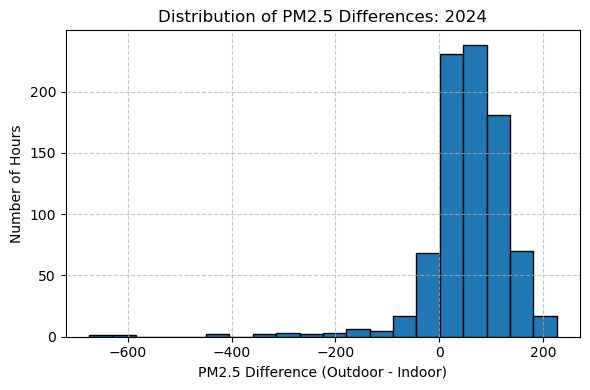

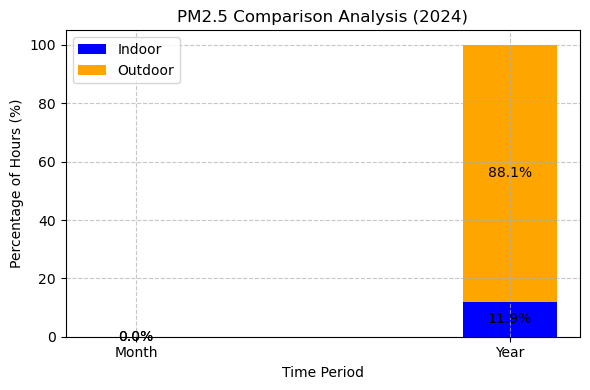


Analyzing device pair: Indoor 1203240077 - Outdoor DELDPCC014

No data available for Month 8/2024

PM2.5 Analysis for Year 2024
Total hours analyzed: 1779
Hours where indoor PM2.5 > outdoor PM2.5: 545 (30.64%)
Hours where outdoor PM2.5 > indoor PM2.5: 1234 (69.36%)

No data available for Month 8/2024


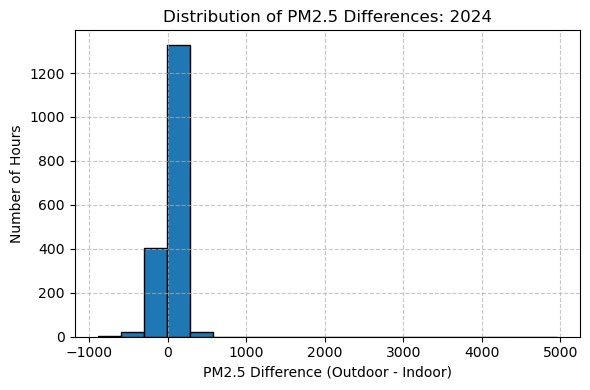

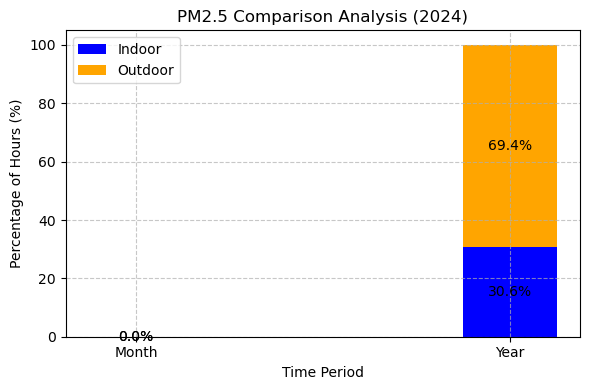


Analyzing device pair: Indoor 1203240082 - Outdoor DELDPCC014

No data available for Month 8/2024

PM2.5 Analysis for Year 2024
Total hours analyzed: 1494
Hours where indoor PM2.5 > outdoor PM2.5: 341 (22.82%)
Hours where outdoor PM2.5 > indoor PM2.5: 1153 (77.18%)

No data available for Month 8/2024


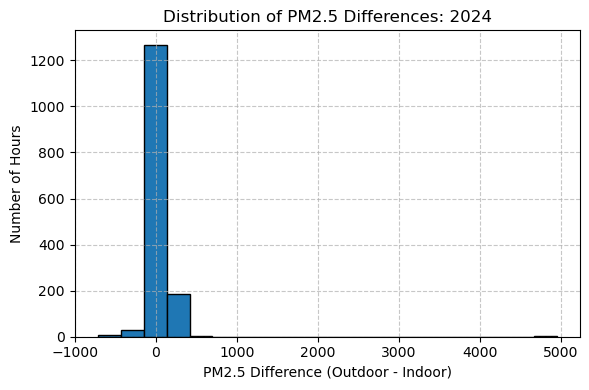

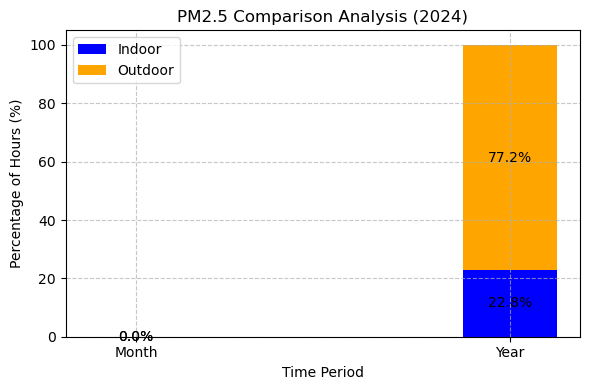


Analyzing device pair: Indoor 1203240078 - Outdoor DELCPCB010

No data available for Month 8/2024

PM2.5 Analysis for Year 2024
Total hours analyzed: 411
Hours where indoor PM2.5 > outdoor PM2.5: 221 (53.77%)
Hours where outdoor PM2.5 > indoor PM2.5: 190 (46.23%)

No data available for Month 8/2024


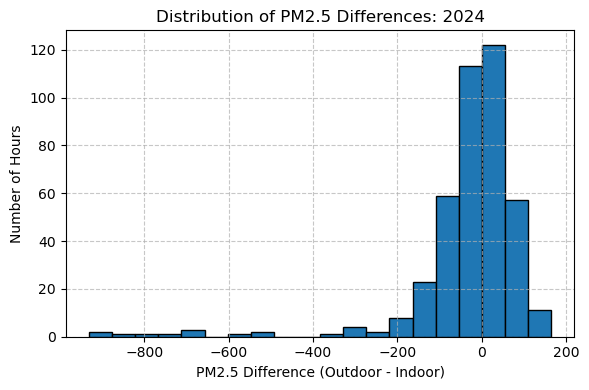

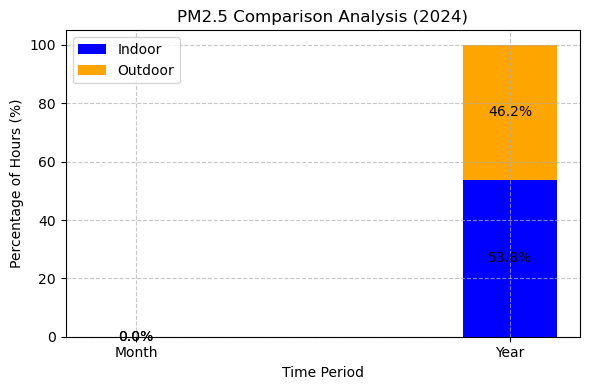


Analyzing device pair: Indoor 1203240076 - Outdoor DELCPCB010

No data available for Month 8/2024

PM2.5 Analysis for Year 2024
Total hours analyzed: 392
Hours where indoor PM2.5 > outdoor PM2.5: 301 (76.79%)
Hours where outdoor PM2.5 > indoor PM2.5: 91 (23.21%)

No data available for Month 8/2024


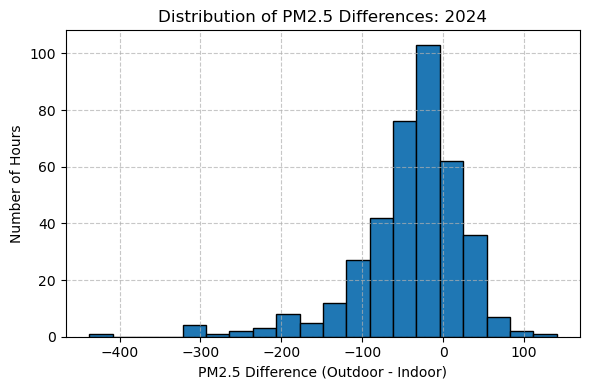

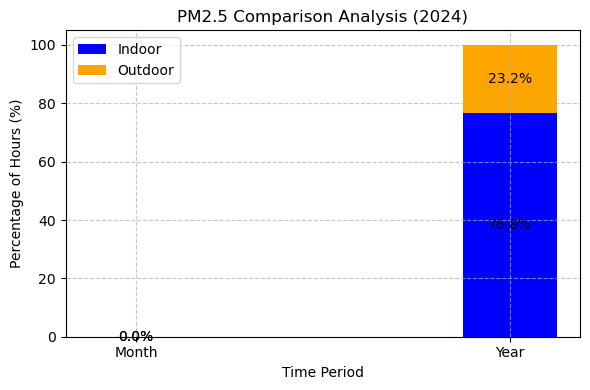


Analyzing device pair: Indoor 1203240079 - Outdoor DELDPCC006

No data available for Month 8/2024

No data available for Year 2024

No data available for Month 8/2024

No data available for Year 2024


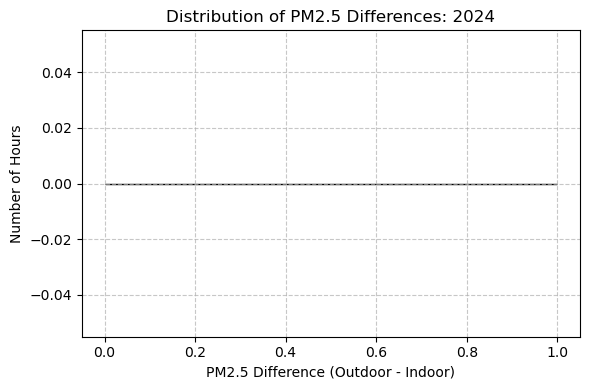

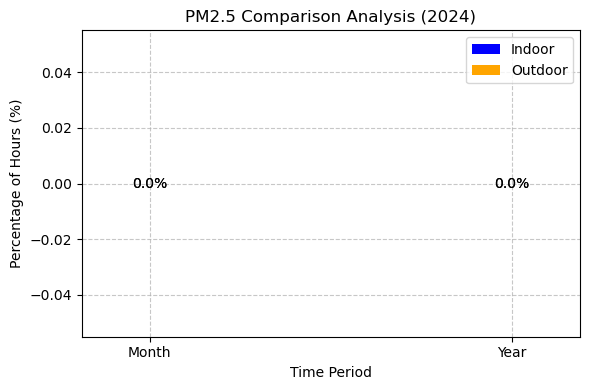


Analyzing device pair: Indoor 1203240081 - Outdoor THIRD_DPCC_SCR_RKPURAM

No data available for Month 8/2024

PM2.5 Analysis for Year 2024
Total hours analyzed: 1362
Hours where indoor PM2.5 > outdoor PM2.5: 392 (28.78%)
Hours where outdoor PM2.5 > indoor PM2.5: 970 (71.22%)

No data available for Month 8/2024


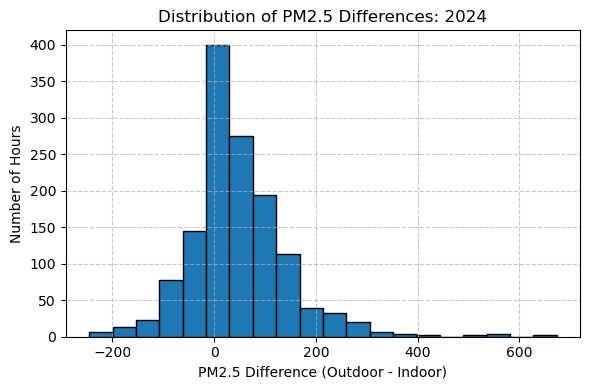

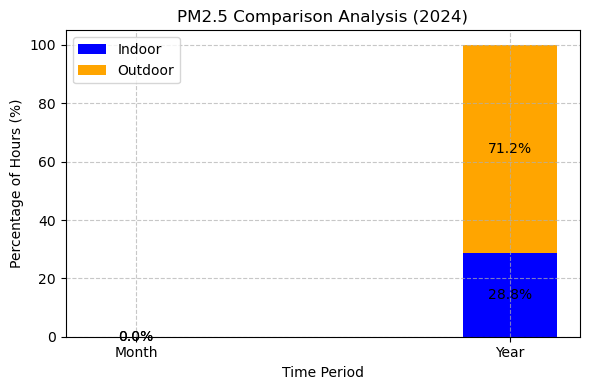


Analyzing device pair: Indoor 1203240073 - Outdoor DELDPCC018

No data available for Month 8/2024

PM2.5 Analysis for Year 2024
Total hours analyzed: 1467
Hours where indoor PM2.5 > outdoor PM2.5: 1120 (76.35%)
Hours where outdoor PM2.5 > indoor PM2.5: 347 (23.65%)

No data available for Month 8/2024


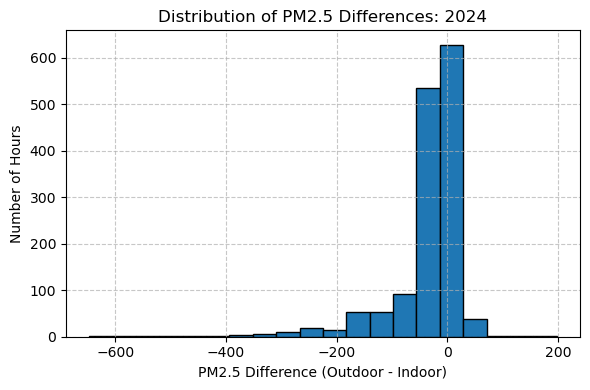

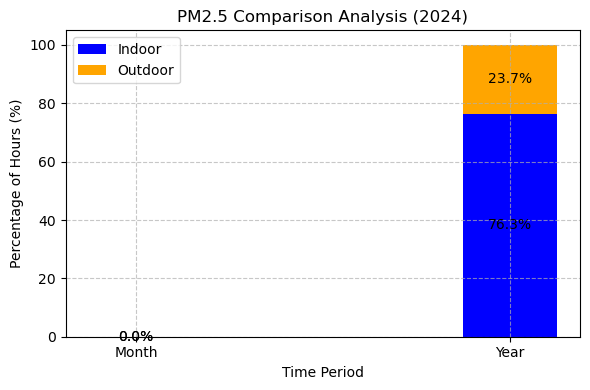


Analyzing device pair: Indoor 1203240074 - Outdoor DELDPCC011

No data available for Month 8/2024

PM2.5 Analysis for Year 2024
Total hours analyzed: 1961
Hours where indoor PM2.5 > outdoor PM2.5: 750 (38.25%)
Hours where outdoor PM2.5 > indoor PM2.5: 1211 (61.75%)

No data available for Month 8/2024


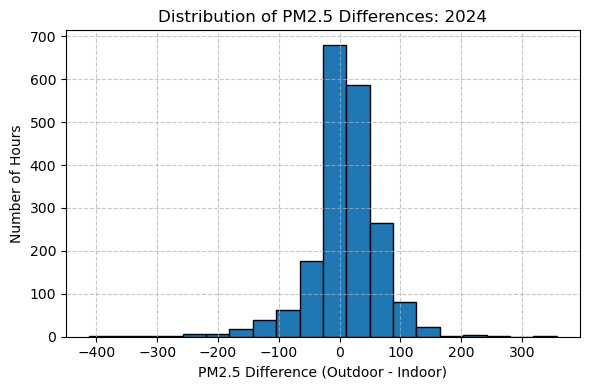

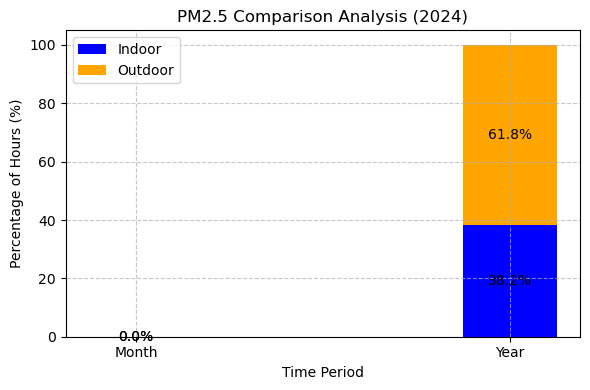


Analyzing device pair: Indoor 1203240075 - Outdoor DELCPCB010

No data available for Month 8/2024

PM2.5 Analysis for Year 2024
Total hours analyzed: 134
Hours where indoor PM2.5 > outdoor PM2.5: 125 (93.28%)
Hours where outdoor PM2.5 > indoor PM2.5: 9 (6.72%)

No data available for Month 8/2024


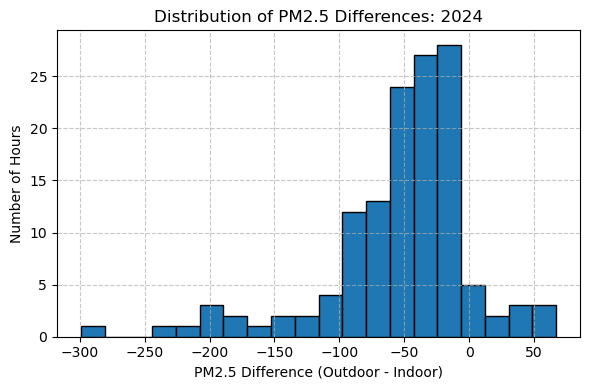

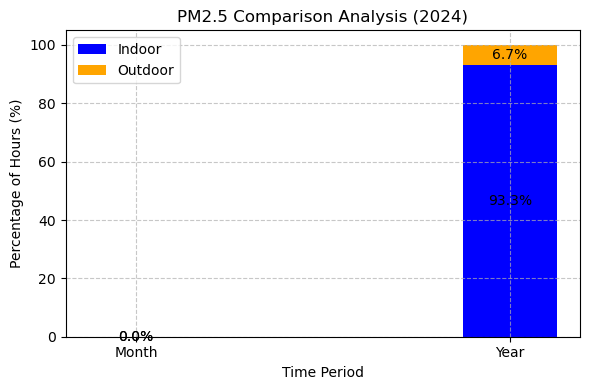


Analyzing device pair: Indoor 1203240083 - Outdoor THIRD_DPCC_SCR_RKPURAM

No data available for Month 8/2024

PM2.5 Analysis for Year 2024
Total hours analyzed: 1729
Hours where indoor PM2.5 > outdoor PM2.5: 370 (21.40%)
Hours where outdoor PM2.5 > indoor PM2.5: 1359 (78.60%)

No data available for Month 8/2024


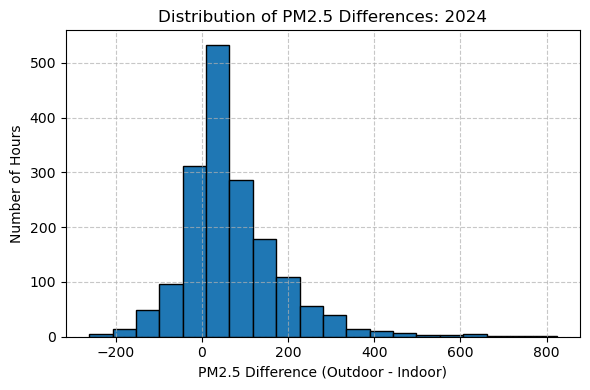

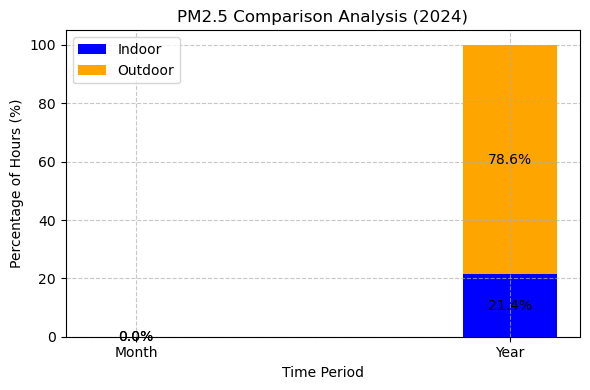


Analyzing device pair: Indoor 1201240072 - Outdoor DELDPCC016

No data available for Month 8/2024

PM2.5 Analysis for Year 2024
Total hours analyzed: 60
Hours where indoor PM2.5 > outdoor PM2.5: 26 (43.33%)
Hours where outdoor PM2.5 > indoor PM2.5: 34 (56.67%)

No data available for Month 8/2024


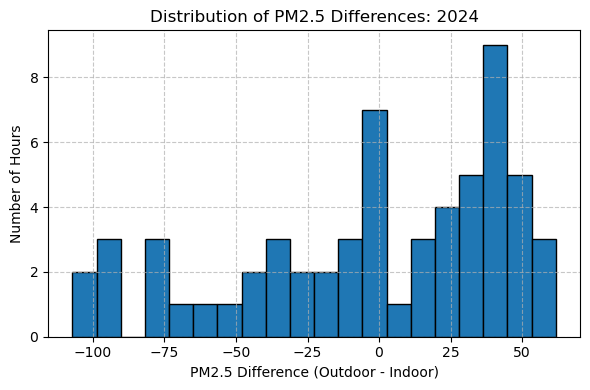

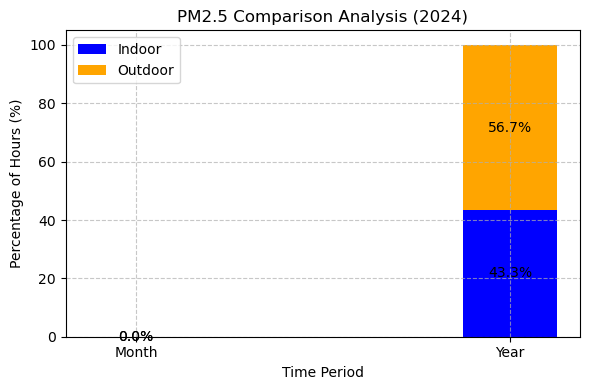

In [21]:
def analyze_all_devices_pm25(year, month):
    try:
        conn = mysql.connector.connect(**DB_CONFIG)
        cursor = conn.cursor()

        # Get all indoor devices
        indoor_devices_query = """
            SELECT DISTINCT deviceID 
            FROM reading_db 
            WHERE YEAR(datetime) = %s;
        """
        cursor.execute(indoor_devices_query, (year,))
        indoor_devices = cursor.fetchall()

        # Get all outdoor devices
        outdoor_devices_query = """
            SELECT DISTINCT deviceID 
            FROM cpcb_data 
            WHERE YEAR(datetime) = %s;
        """
        cursor.execute(outdoor_devices_query, (year,))
        outdoor_devices = [device[0] for device in cursor.fetchall()]

        # Dictionary mapping indoor devices to their nearest outdoor device
        device_mapping = {
            "1202240026": "THIRD_DPCC_SCR_RKPURAM",
            "1202240025": "THIRD_DPCC_SCR_RKPURAM",
            "1203240081": "THIRD_DPCC_SCR_RKPURAM",
            "1201240075": "CPCB1703205345",
            "1202240011": "DELCPCB010",
            "1202240027": "DELCPCB010",
            "1203240076": "DELCPCB010",
            "1203240078": "DELCPCB010",
            "1203240075": "DELCPCB010",
            "1201240077": "DELDPCC016",
            "1201240072": "DELDPCC016",
            "1203240079": "DELDPCC006",
            "1201240079": "DELDPCC006",
            "1201240085": "DELDPCC006",
            "1203240083": "THIRD_DPCC_SCR_RKPURAM",
            "1203240073": "DELDPCC018",
            "1203240074": "DELDPCC011",
            "1201240076": "DELDPCC018",
            "1212230160": "DELDPCC018",
            "1202240009": "DELDPCC018",
            "1202240008": "DELDPCC018",
            "1201240073": "DELDPCC018",
            "1203240080": "DELCPCB005",
            "1201240074": "DELCPCB005",
            "1203240077": "DELDPCC014",
            "1203240082": "DELDPCC014",
            "1202240029": "DELDPCC016",
            "1202240028": "DELDPCC016",
            "1202240010": "DELDPCC016",
            
            "1202240012": "DELDPCC016"
             }

        for indoor_device in indoor_devices:
            indoor_id = indoor_device[0]
            if indoor_id in device_mapping:
                outdoor_id = device_mapping[indoor_id]
                if outdoor_id in outdoor_devices:
                    print(f"\nAnalyzing device pair: Indoor {indoor_id} - Outdoor {outdoor_id}")
                    analyze_indoor_outdoor_pm25(indoor_id, outdoor_id, year, month)
                else:
                    print(f"Outdoor device {outdoor_id} not found in data for year {year}")
            else:
                print(f"No outdoor device mapping found for indoor device {indoor_id}")

    except mysql.connector.Error as err:
        print(f"Database error: {err}")

    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()

# Example usage
analyze_all_devices_pm25(2024, 8)

#### Annual Indoor Outdoor line chart 

No valid outdoor data for April 2024
Found 25 outdoor records for May 2024
Found 30 outdoor records for June 2024
Found 31 outdoor records for July 2024
Found 31 outdoor records for August 2024
Found 30 outdoor records for September 2024
Found 31 outdoor records for October 2024
Found 24 outdoor records for November 2024
Found 30 outdoor records for December 2024
Found 31 outdoor records for January 2025
Found 28 outdoor records for February 2025
Found 30 outdoor records for March 2025
Found 30 outdoor records for April 2025


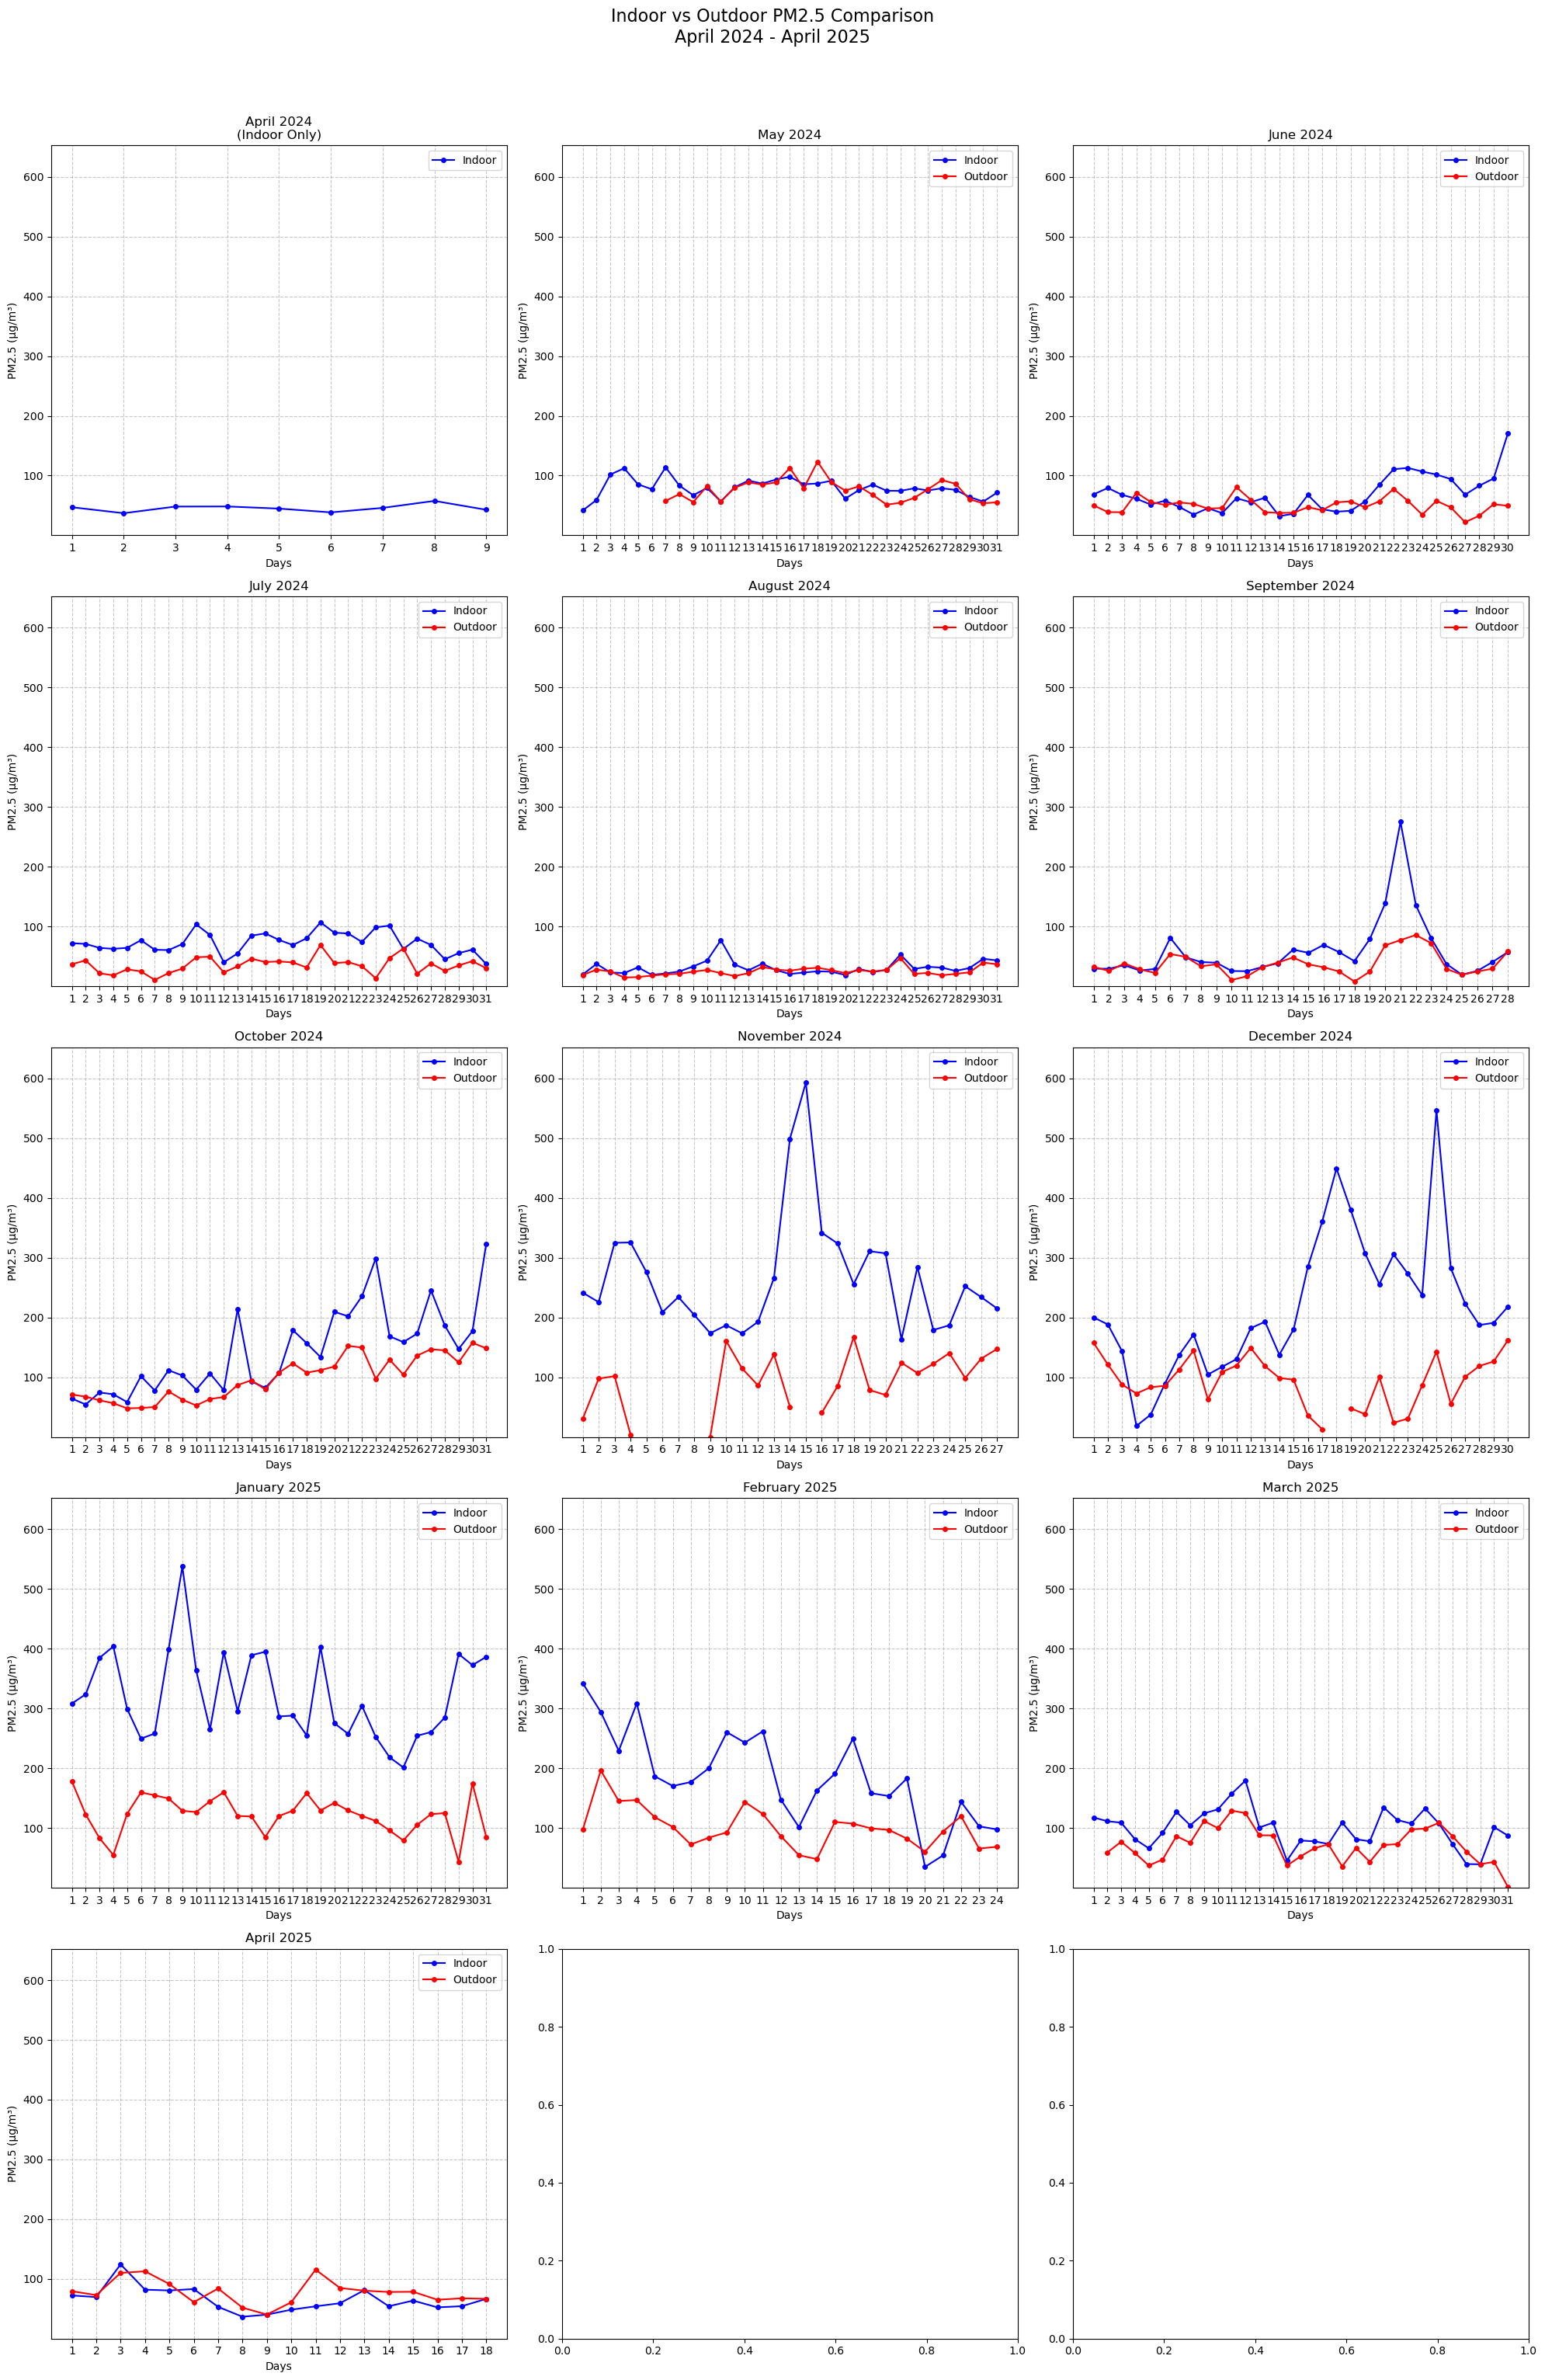

In [31]:
import os
DEVICE_MAPPING = {
    "1202240026": "THIRD_DPCC_SCR_RKPURAM",
    "1202240025": "THIRD_DPCC_SCR_RKPURAM",
    "1203240081": "THIRD_DPCC_SCR_RKPURAM",
    "1201240075": "CPCB1703205345",
    "1202240011": "DELCPCB010",
    "1202240027": "DELCPCB010",
    "1203240076": "DELCPCB010",
    "1203240078": "DELCPCB010",
    "1203240075": "DELCPCB010",
    "1201240077": "DELDPCC016",
    "1201240072": "DELDPCC016",
    "1203240079": "DELDPCC006",
    "1201240079": "DELDPCC006",
    "1201240085": "DELDPCC006",
    "1203240083": "THIRD_DPCC_SCR_RKPURAM",
    "1203240073": "DELDPCC018",
    "1203240074": "DELDPCC011",
    "1201240076": "DELDPCC018",
    "1212230160": "DELDPCC018",
    "1202240009": "DELDPCC018",
    "1202240008": "DELDPCC018",
    "1201240073": "DELDPCC018",
    "1203240080": "DELCPCB005",
    "1201240074": "DELCPCB005",
    "1203240077": "DELDPCC014",
    "1203240082": "DELDPCC014",
    "1202240029": "DELDPCC016",
    "1202240028": "DELDPCC016",
    "1202240010": "DELDPCC016",
    "1202240012": "DELDPCC016"
}

def plot_yearly_indoor_outdoor_comparison(indoor_device_id, outdoor_device_id, start_date=(2024, 5), end_date=(2025, 4)):
    """Create a grid of line charts showing indoor vs outdoor PM2.5 values for specified date range."""
    try:
        # Create directory for CSV files
        csv_dir = f'data_pm25_{indoor_device_id}_{start_date[0]}_{start_date[1]}_to_{end_date[0]}_{end_date[1]}'
        os.makedirs(csv_dir, exist_ok=True)

        # Calculate number of months between dates
        start_year, start_month = start_date
        end_year, end_month = end_date
        total_months = (end_year - start_year) * 12 + end_month - start_month + 1
        
        if total_months <= 0:
            print("Invalid date range")
            return

        # Adjust grid layout based on number of months
        rows = (total_months + 2) // 3
        fig, axes = plt.subplots(rows, 3, figsize=(20, 6 * rows))
        axes = axes.flatten()

        # Generate date range
        date_range = []
        for i in range(total_months):
            year = start_year + (start_month + i - 1) // 12
            month = ((start_month + i - 1) % 12) + 1
            date_range.append((year, month))

        all_pm25_values = []
        month_data = {}

        for year, month in date_range:
            conn = mysql.connector.connect(**DB_CONFIG)
            cursor = conn.cursor()

            # Outdoor data query
            outdoor_query = """
                SELECT DATE(datetime) as date, AVG(pm25) as pm25
                FROM cpcb_data 
                WHERE deviceID = %s AND YEAR(datetime) = %s AND MONTH(datetime) = %s
                GROUP BY DATE(datetime);
            """
            
            # Indoor data query
            indoor_query = """
                SELECT DATE(datetime) as date, AVG(pm25) as pm25
                FROM reading_db
                WHERE deviceID = %s AND YEAR(datetime) = %s AND MONTH(datetime) = %s
                GROUP BY DATE(datetime);
            """

            # Get indoor data first
            cursor.execute(indoor_query, (indoor_device_id, year, month))
            indoor_data = cursor.fetchall()
            indoor_df = pd.DataFrame(indoor_data, columns=['date', 'indoor_pm25'])
            indoor_df = indoor_df[indoor_df['indoor_pm25'] != 0]
            indoor_df = indoor_df[indoor_df['indoor_pm25'].notna()]

            has_outdoor = False
            if not indoor_df.empty:
                try:
                    # Try to get outdoor data with proper error handling
                    cursor.execute(outdoor_query, (outdoor_device_id, year, month))
                    outdoor_data = cursor.fetchall()
                    if outdoor_data:
                        outdoor_df = pd.DataFrame(outdoor_data, columns=['date', 'outdoor_pm25'])
                        outdoor_df = outdoor_df[outdoor_df['outdoor_pm25'] != 0]
                        outdoor_df = outdoor_df[outdoor_df['outdoor_pm25'].notna()]
                        
                        if not outdoor_df.empty:
                            print(f"Found {len(outdoor_df)} outdoor records for {calendar.month_name[month]} {year}")
                            merged_df = pd.merge(indoor_df, outdoor_df, on='date', how='left')
                            has_outdoor = True
                        else:
                            print(f"No valid outdoor data for {calendar.month_name[month]} {year}")
                            merged_df = indoor_df.copy()
                            merged_df['outdoor_pm25'] = None
                    else:
                        print(f"No outdoor data found for {calendar.month_name[month]} {year}")
                        merged_df = indoor_df.copy()
                        merged_df['outdoor_pm25'] = None
                except Exception as e:
                    print(f"Error getting outdoor data: {e}")
                    merged_df = indoor_df.copy()
                    merged_df['outdoor_pm25'] = None

                all_pm25_values.extend(merged_df['indoor_pm25'].tolist())
                if has_outdoor:
                    all_pm25_values.extend(merged_df['outdoor_pm25'].dropna().tolist())

                # # Save monthly data to CSV
                # if not merged_df.empty:
                #     csv_filename = f'{csv_dir}/pm25_data_{year}_{month:02d}.csv'
                    # merged_df.to_csv(f'testing_{month}.csv', index=False)
                #     print(f"Saved data for {calendar.month_name[month]} {year} to {csv_filename}")

                month_data[(year, month)] = (merged_df, has_outdoor)
            
            cursor.close()
            conn.close()

        # Set y-axis limits with padding
        if all_pm25_values:
            ymin = max(0, min(all_pm25_values) * 0.9)
            ymax = max(all_pm25_values) * 1.1
        else:
            ymin, ymax = 0, 100  # fallback

        # Modified plotting code
        for i, (year, month) in enumerate(date_range):
            ax = axes[i]
            if (year, month) in month_data:
                df, has_outdoor = month_data[(year, month)]
                days = range(1, len(df) + 1)  # Start from 1 instead of 0
                ax.plot(days, df['indoor_pm25'], 
                       label='Indoor', color='blue', marker='o', markersize=4)
                
                if has_outdoor:
                    ax.plot(days, df['outdoor_pm25'], 
                           label='Outdoor', color='red', marker='o', markersize=4)
                    ax.set_title(f'{calendar.month_name[month]} {year}')
                else:
                    ax.set_title(f'{calendar.month_name[month]} {year}\n(Indoor Only)')
                
                ax.set_xlabel('Days')
                ax.set_ylabel('PM2.5 (μg/m³)')
                ax.set_ylim(ymin, ymax)
                # Set x-axis ticks to show whole numbers
                ax.set_xticks(days)
                ax.grid(True, linestyle='--', alpha=0.7)
                ax.legend()
            else:
                ax.text(0.5, 0.5, 'No Data Available', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{calendar.month_name[month]} {year}')
                ax.set_ylim(ymin, ymax)

        plt.suptitle(f'Indoor vs Outdoor PM2.5 Comparison\n{calendar.month_name[start_month]} {start_year} - {calendar.month_name[end_month]} {end_year}', 
                    y=1.02, fontsize=16)
        plt.tight_layout()
        # filename = f'comparison_pm25_{indoor_device_id}_{outdoor_device_id}_{start_year}_{start_month}_{end_year}_{end_month}.png'
        # plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        # print(f"Saved comparison plot as: {filename}")

    except mysql.connector.Error as err:
        print(f"Database error: {err}")


# Example usage with date range
plot_yearly_indoor_outdoor_comparison(1201240076, 'DELCPCB005', 
                                    start_date=(2024, 4), 
                                    end_date=(2025, 4)) 


### Line Chart of particular Day in every months 

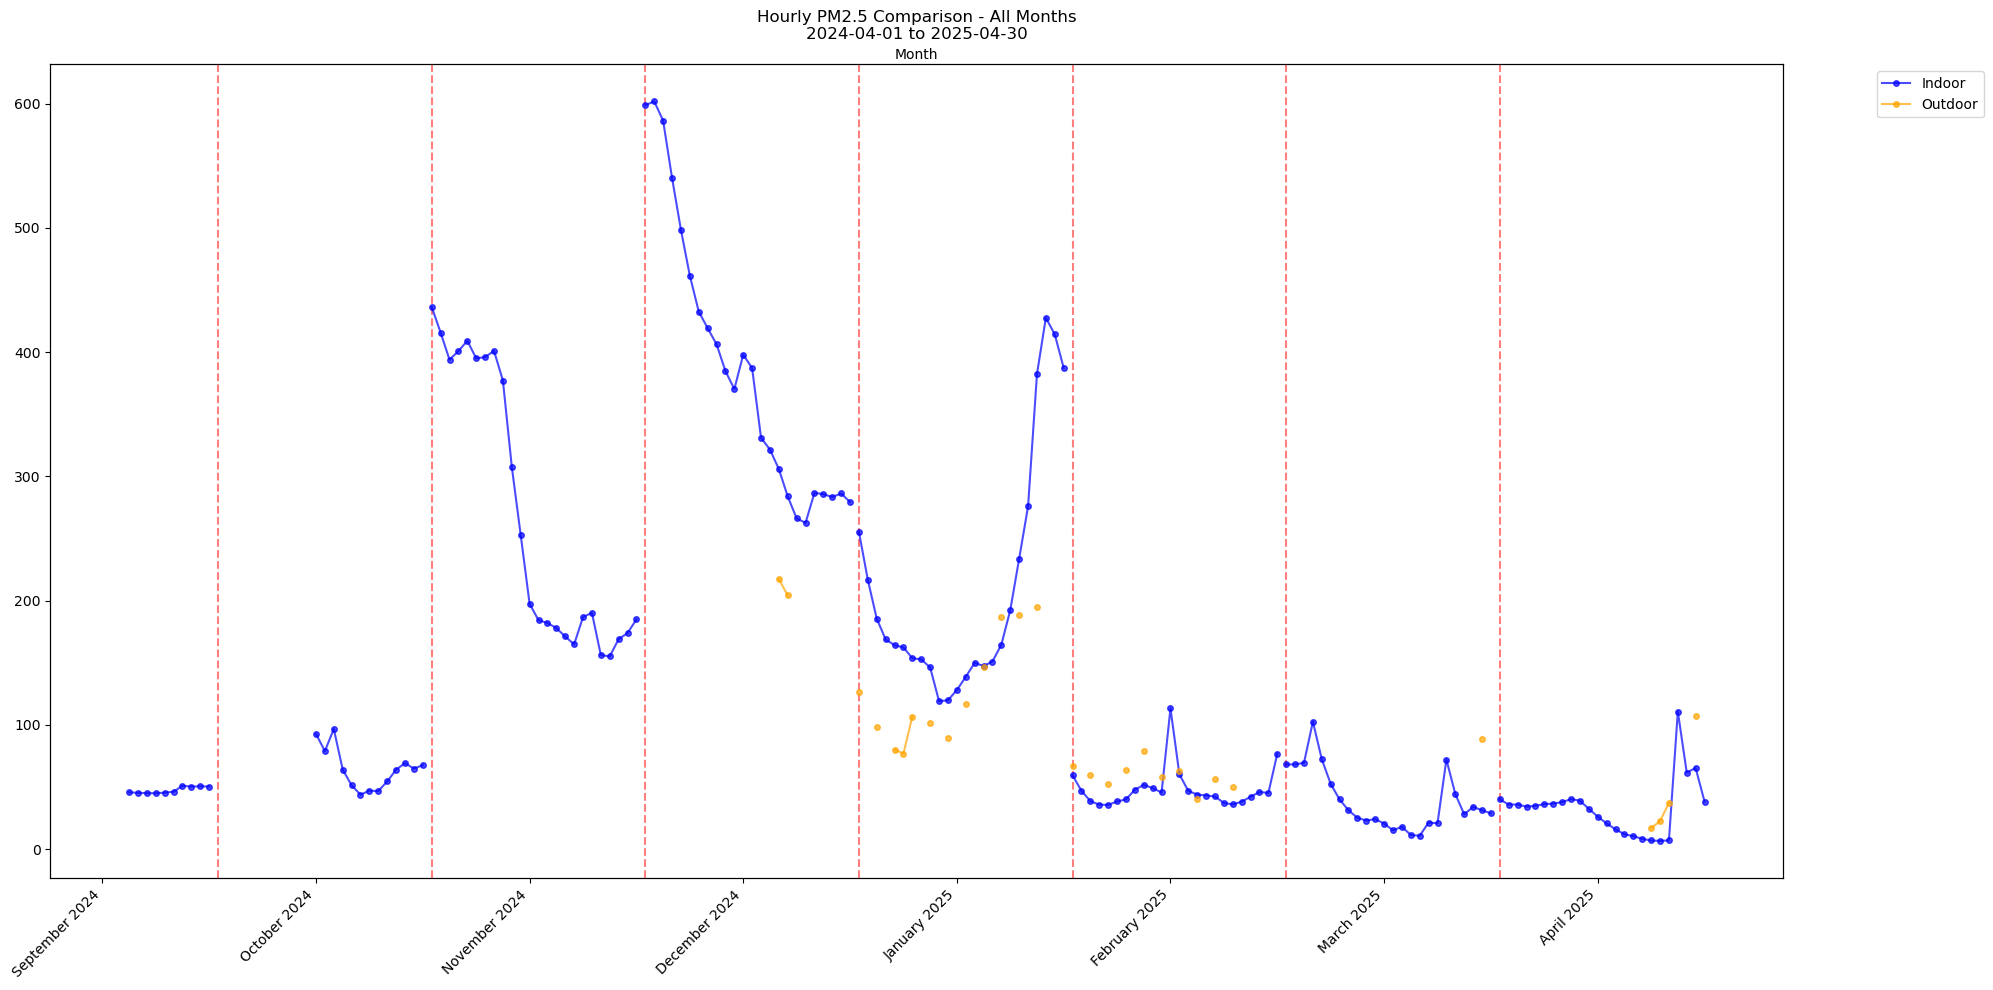

In [64]:
def plot_monthly_hourly_comparison(indoor_device_id, outdoor_device_id, start_date, end_date):
    """Plot hourly comparison for all months in a single chart."""
    try:
        conn = mysql.connector.connect(**DB_CONFIG)
        cursor = conn.cursor()
        
        # Calculate number of rows and columns for subplot grid
        months_data = []
        current_date = start_date
        month_count = 0
        
        while current_date <= end_date:
            year = current_date.year
            month = current_date.month
            month_count += 1
            
            # Find day with most non-zero data points
            best_day_query = """
                SELECT DAY(datetime) as day, COUNT(*) as count
                FROM reading_db
                WHERE deviceID = %s 
                AND YEAR(datetime) = %s 
                AND MONTH(datetime) = %s
                AND datetime BETWEEN %s AND %s
                AND pm25 > 0  -- Exclude zero values
                GROUP BY DAY(datetime)
                ORDER BY count DESC
                LIMIT 1;
            """
            cursor.execute(best_day_query, (indoor_device_id, year, month, start_date, end_date))
            best_day_result = cursor.fetchone()
            
            if best_day_result:
                best_day = best_day_result[0]
                
                # Get hourly averages for best day (excluding zeros)
                indoor_query = """
                    SELECT HOUR(datetime) as hour, 
                           AVG(pm25) as pm25
                    FROM reading_db
                    WHERE deviceID = %s 
                    AND YEAR(datetime) = %s 
                    AND MONTH(datetime) = %s
                    AND DAY(datetime) = %s
                    AND pm25 > 0  -- Exclude zero values
                    GROUP BY HOUR(datetime)
                    ORDER BY hour;
                """
                cursor.execute(indoor_query, (indoor_device_id, year, month, best_day))
                indoor_data = pd.DataFrame(cursor.fetchall(), columns=['hour', 'indoor_pm25'])

                outdoor_query = """
                    SELECT HOUR(datetime) as hour, 
                           AVG(pm25) as pm25
                    FROM cpcb_data
                    WHERE deviceID = %s 
                    AND YEAR(datetime) = %s 
                    AND MONTH(datetime) = %s
                    AND DAY(datetime) = %s
                    AND pm25 > 0  -- Exclude zero values
                    GROUP BY HOUR(datetime)
                    ORDER BY hour;
                """
                cursor.execute(outdoor_query, (outdoor_device_id, year, month, best_day))
                outdoor_data = pd.DataFrame(cursor.fetchall(), columns=['hour', 'outdoor_pm25'])
                
                # Merge hourly data
                hourly_data = pd.merge(indoor_data, outdoor_data, on='hour', how='outer')
                months_data.append({
                    'month': month,
                    'year': year,
                    'month_name': f"{calendar.month_name[month]} {year}",
                    'day': best_day,
                    'hourly_data': hourly_data
                })
            
            if month == 12:
                current_date = datetime(year + 1, 1, 1)
            else:
                current_date = datetime(year, month + 1, 1)
        
        # Create a single large figure
        plt.figure(figsize=(20, 10))
        
        # Fixed colors for indoor and outdoor
        INDOOR_COLOR = 'blue'
        OUTDOOR_COLOR = 'orange'
        
        # Initialize lists to store line objects for legend
        indoor_lines = []
        outdoor_lines = []
        
        for idx, month_data in enumerate(months_data):
            hourly_data = month_data['hourly_data']
            month_offset = idx * 24
            x_hours = [h + month_offset for h in hourly_data['hour']]
            
            # Save line objects
            indoor_line, = plt.plot(x_hours, hourly_data['indoor_pm25'], '-o', 
                                  color=INDOOR_COLOR, markersize=4, alpha=0.7)
            outdoor_line, = plt.plot(x_hours, hourly_data['outdoor_pm25'], '-o', 
                                   color=OUTDOOR_COLOR, markersize=4, alpha=0.7)
            
            indoor_lines.append(indoor_line)
            outdoor_lines.append(outdoor_line)
            
            if idx < len(months_data) - 1:
                plt.axvline(x=(idx + 1) * 24, color='red', linestyle='--', alpha=0.5)
        
        # Create legend with first line of each type
        if indoor_lines and outdoor_lines:
            indoor_lines[0].set_label('Indoor')
            outdoor_lines[0].set_label('Outdoor')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Set x-axis ticks and labels
        all_hours = []
        month_labels = []
        month_positions = []
        
        for idx, month_data in enumerate(months_data):
            month_start = idx * 24
            all_hours.extend(range(month_start, month_start + 24))
            month_positions.append(month_start + 11)  # Center of each month
            month_labels.append(month_data['month_name'])
        
        plt.xticks(month_positions, month_labels, rotation=45, ha='right')
        
        # Add secondary x-axis for hours
        ax2 = plt.gca().twiny()
        ax2.set_xlim(plt.gca().get_xlim())
        ax2.set_xticks([])
        ax2.set_xlabel('Hour of Day')
        
        plt.title(f'Hourly PM2.5 Comparison - All Months\n{start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')
        plt.xlabel('Month')
        plt.ylabel('PM2.5 (μg/m³)')
        plt.grid(True, linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        cursor.close()
        conn.close()

    except mysql.connector.Error as err:
        print(f"Database error: {err}")

from datetime import datetime
import numpy as np
start_date = datetime(2024, 4, 1)
end_date = datetime(2025, 4, 30)
plot_monthly_hourly_comparison("1203240075", "DELCPCB010", start_date, end_date)


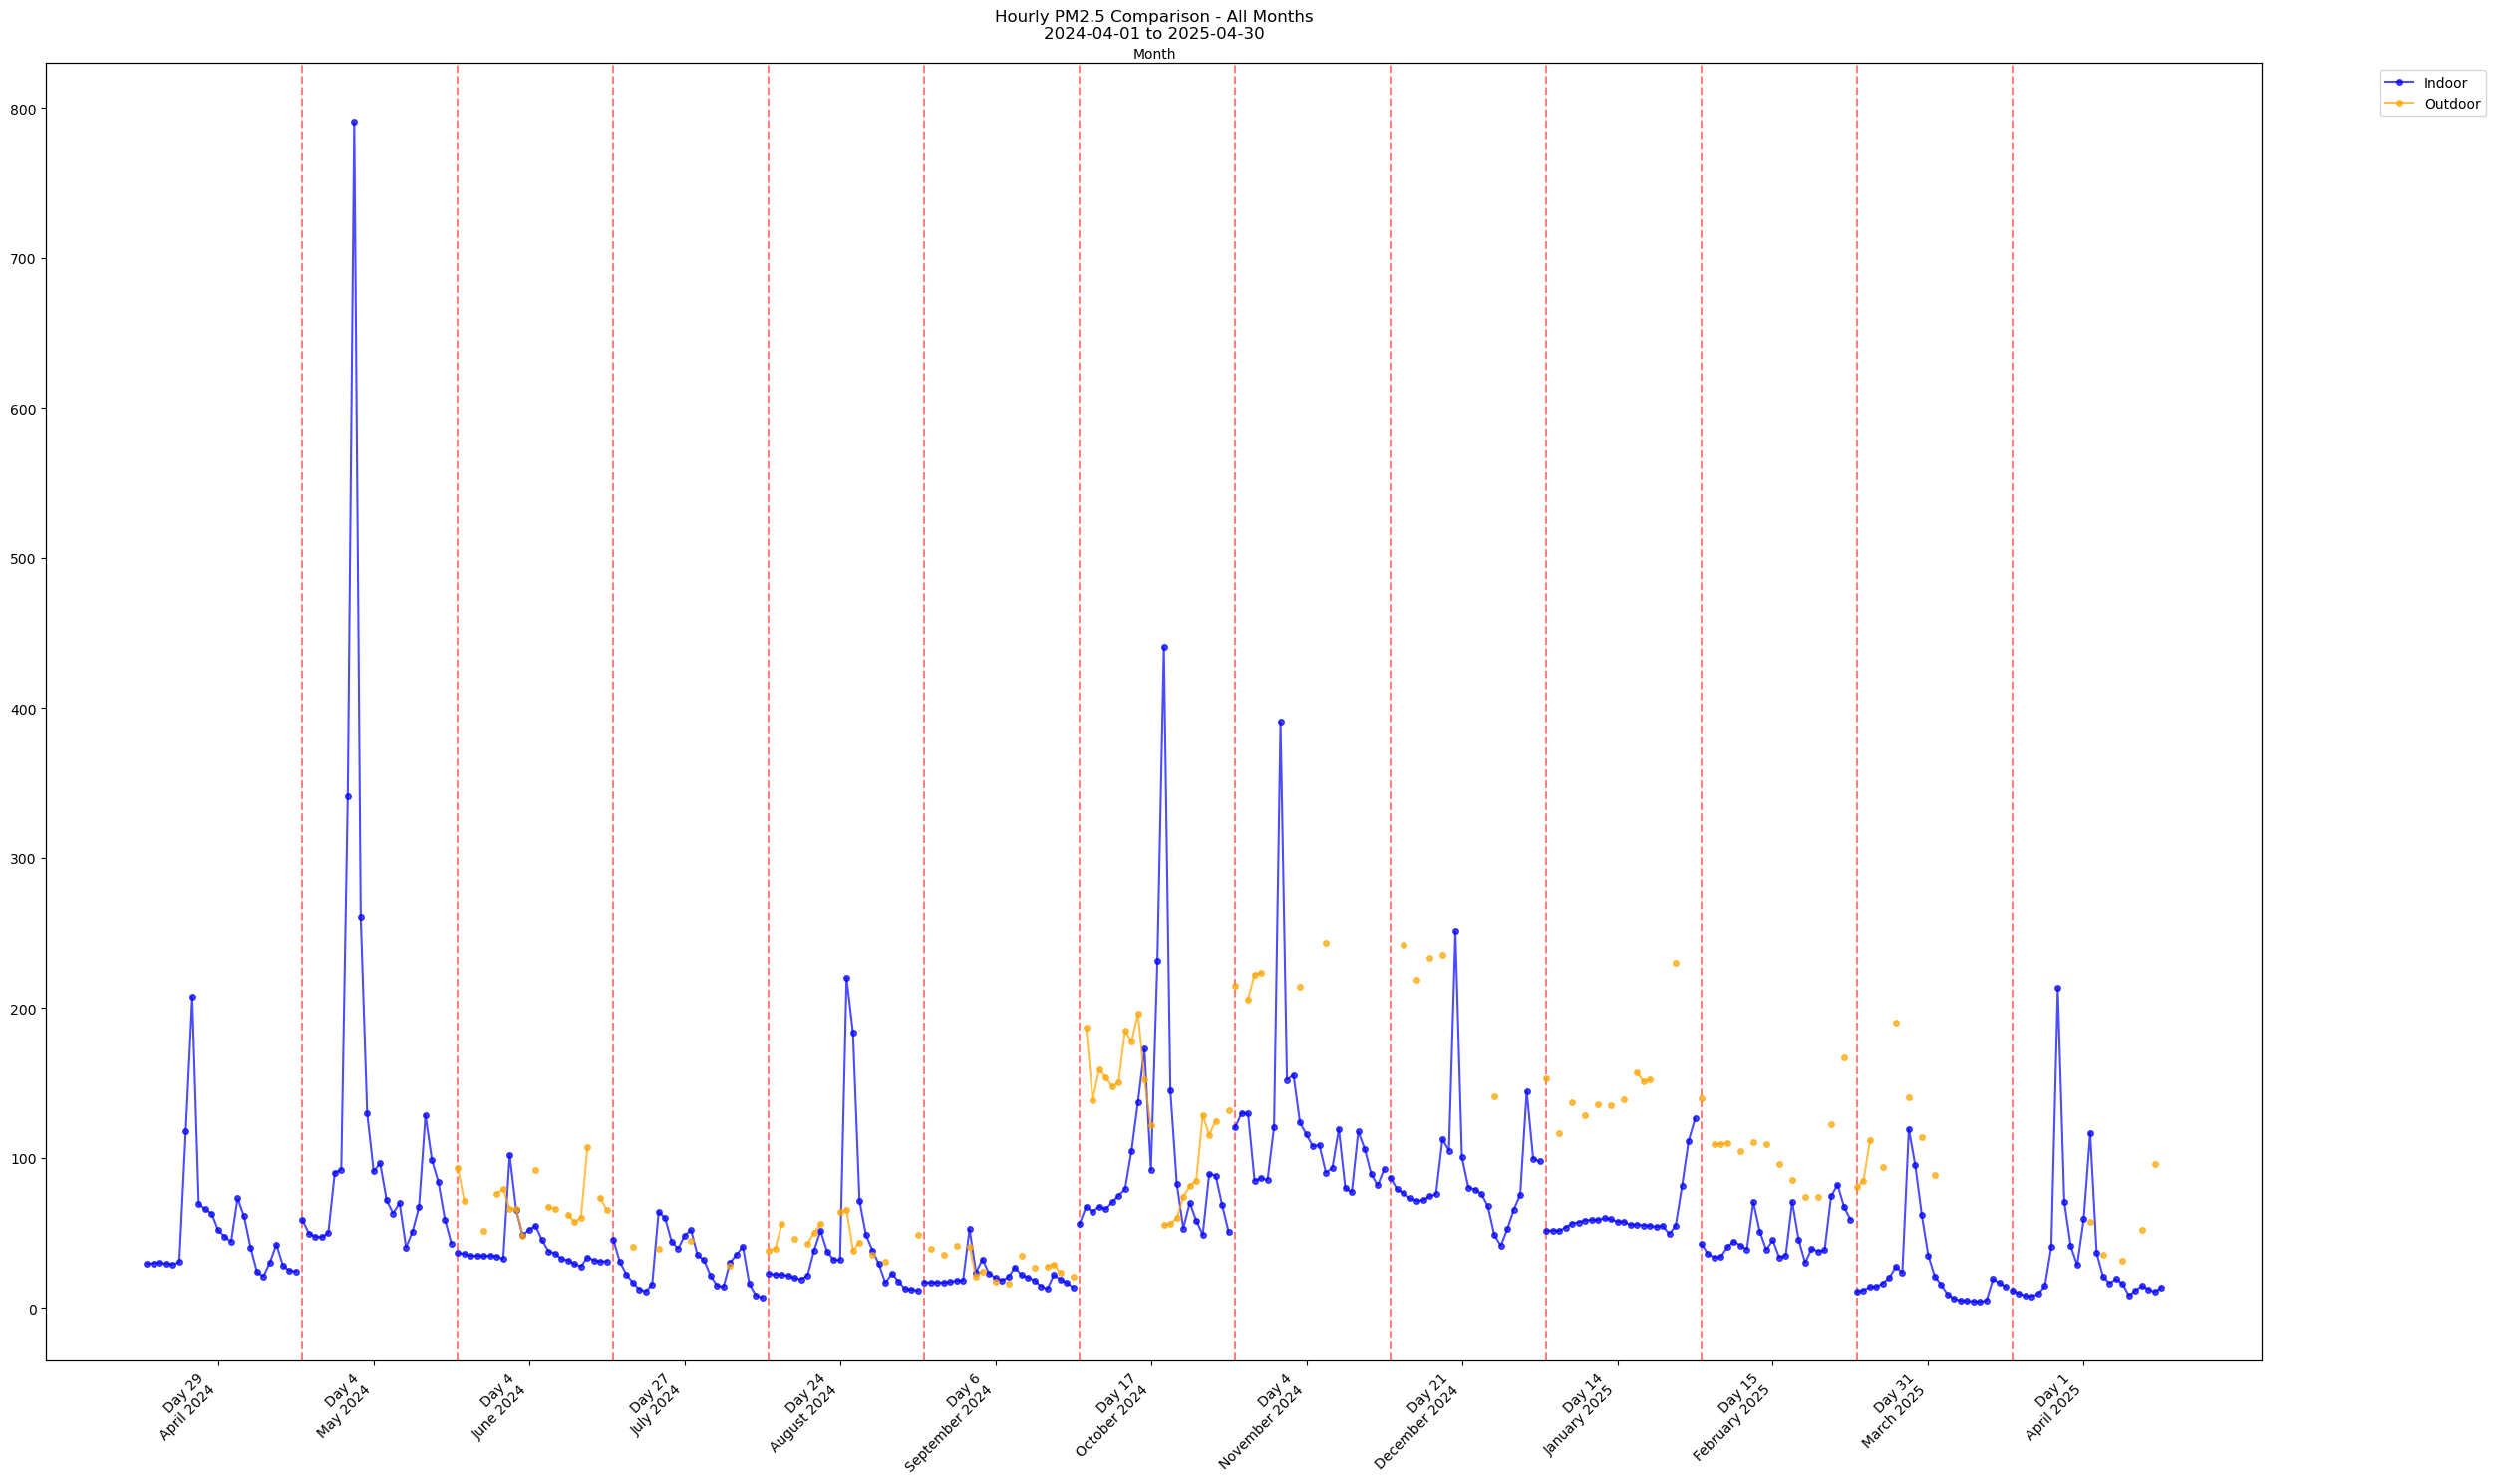

In [72]:
def plot_monthly_hourly_comparison(indoor_device_id, outdoor_device_id, start_date, end_date):
    """Plot hourly comparison for all months in a single chart."""
    try:
        conn = mysql.connector.connect(**DB_CONFIG)
        cursor = conn.cursor()
        
        # Calculate number of rows and columns for subplot grid
        months_data = []
        current_date = start_date
        month_count = 0
        
        while current_date <= end_date:
            year = current_date.year
            month = current_date.month
            month_count += 1
            
            # Find day with most non-zero data points
            best_day_query = """
                SELECT DAY(datetime) as day, COUNT(*) as count
                FROM reading_db
                WHERE deviceID = %s 
                AND YEAR(datetime) = %s 
                AND MONTH(datetime) = %s
                AND datetime BETWEEN %s AND %s
                AND pm25 > 0  
                GROUP BY DAY(datetime)
                ORDER BY count DESC
                LIMIT 1;
            """
            cursor.execute(best_day_query, (indoor_device_id, year, month, start_date, end_date))
            best_day_result = cursor.fetchone()
            
            if best_day_result:
                best_day = best_day_result[0]
                
                # Get hourly averages for best day (excluding zeros)
                indoor_query = """
                    SELECT HOUR(datetime) as hour, 
                           AVG(pm25) as pm25
                    FROM reading_db
                    WHERE deviceID = %s 
                    AND YEAR(datetime) = %s 
                    AND MONTH(datetime) = %s
                    AND DAY(datetime) = %s
                    AND pm25 > 0  
                    GROUP BY HOUR(datetime)
                    ORDER BY hour;
                """
                cursor.execute(indoor_query, (indoor_device_id, year, month, best_day))
                indoor_data = pd.DataFrame(cursor.fetchall(), columns=['hour', 'indoor_pm25'])

                outdoor_query = """
                    SELECT HOUR(datetime) as hour, 
                           AVG(pm25) as pm25
                    FROM cpcb_data
                    WHERE deviceID = %s 
                    AND YEAR(datetime) = %s 
                    AND MONTH(datetime) = %s
                    AND DAY(datetime) = %s
                    AND pm25 > 0  
                    GROUP BY HOUR(datetime)
                    ORDER BY hour;
                """
                cursor.execute(outdoor_query, (outdoor_device_id, year, month, best_day))
                outdoor_data = pd.DataFrame(cursor.fetchall(), columns=['hour', 'outdoor_pm25'])
                
                # Merge hourly data
                hourly_data = pd.merge(indoor_data, outdoor_data, on='hour', how='outer')
                months_data.append({
                    'month': month,
                    'year': year,
                    'month_name': f"{calendar.month_name[month]} {year}",
                    'day': best_day,
                    'hourly_data': hourly_data
                })
            
            if month == 12:
                current_date = datetime(year + 1, 1, 1)
            else:
                current_date = datetime(year, month + 1, 1)
        
        # Create a single large figure
        plt.figure(figsize=(25, 15))
        
        # Fixed colors for indoor and outdoor
        INDOOR_COLOR = 'blue'
        OUTDOOR_COLOR = 'orange'
        
        # Initialize lists to store line objects for legend
        indoor_lines = []
        outdoor_lines = []
        
        for idx, month_data in enumerate(months_data):
            hourly_data = month_data['hourly_data']
            month_offset = idx * 24
            x_hours = [h + month_offset for h in hourly_data['hour']]
            
            # Save line objects
            indoor_line, = plt.plot(x_hours, hourly_data['indoor_pm25'], '-o', 
                                  color=INDOOR_COLOR, markersize=4, alpha=0.7)
            outdoor_line, = plt.plot(x_hours, hourly_data['outdoor_pm25'], '-o', 
                                   color=OUTDOOR_COLOR, markersize=4, alpha=0.7)
            
            indoor_lines.append(indoor_line)
            outdoor_lines.append(outdoor_line)
            
            if idx < len(months_data) - 1:
                plt.axvline(x=(idx + 1) * 24, color='red', linestyle='--', alpha=0.5)
        
        # Create legend with first line of each type
        if indoor_lines and outdoor_lines:
            indoor_lines[0].set_label('Indoor')
            outdoor_lines[0].set_label('Outdoor')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Set x-axis ticks and labels
        all_hours = []
        month_labels = []
        month_positions = []
        
        for idx, month_data in enumerate(months_data):
            month_start = idx * 24
            all_hours.extend(range(month_start, month_start + 24))
            month_positions.append(month_start + 11)  # Center of each month
            # Add best day to month label
            month_labels.append(f"Day {month_data['day']}\n{month_data['month_name']}")
        
        plt.xticks(month_positions, month_labels, rotation=45, ha='right')
        
        # Add secondary x-axis for hours
        ax2 = plt.gca().twiny()
        ax2.set_xlim(plt.gca().get_xlim())
        ax2.set_xticks([])
        ax2.set_xlabel('Hour of Day')
        
        plt.title(f'Hourly PM2.5 Comparison - All Months\n{start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')
        plt.xlabel('Month')
        plt.ylabel('PM2.5 (μg/m³)')
        plt.grid(True, linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        cursor.close()
        conn.close()

    except mysql.connector.Error as err:
        print(f"Database error: {err}")

from datetime import datetime
import numpy as np
start_date = datetime(2024, 4, 1)
end_date = datetime(2025, 4, 30)
plot_monthly_hourly_comparison("1201240074", "DELCPCB005", start_date, end_date)
